# first test of all code in `stancode_gallery1`
 * testing some  
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

'''
for i,dataname in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
'''
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
        data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
        data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
                                    data_gridded[dataname]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
                data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[dataname]['obs'] = data[dataname]['obs'][:,:i]
        data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    ## load cross-validation testing indices and add them to data
    #data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    ## remove last index, so that dimensions agree
    #data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[dataname]['obs_count'] = (1000*data[dataname]['obs']).astype(int)
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

In [4]:
'''
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')
'''
None

## run model

In [5]:
import pystan
import re

desc_model = {
    'm5':'m5',
    'm6':'m6',
    'm7':'m7',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm5':(),
    'm6':(),
    'm7':(),
}
model_stan_key = {
    'm5':'c5',
    'm6':'c6',
    'm7':'c7',
}
stan_files = {
    'c5':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowthvol_xval.stan',
    'c6':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowthvol_xval.stan',
    'c7':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowthvol_xval.stan',
    'c5':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowthvol_xval.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5 NOW.


m5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6 NOW.


m6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m7 NOW.


m7: compiling


In [6]:
import time
refit_all = False

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

def get_mean_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmean(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}
if 'meanrhats' not in globals():
    meanrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}

    
try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    if name not in meanrhats:
        meanrhats[name] = {}
    if name not in sampling_time:
        sampling_time[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if dataname not in meanrhats[name]:
            meanrhats[name][dataname] = []
        if dataname not in sampling_time[name]:
            sampling_time[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            t0 = time.time()
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            sampling_time[name][dataname].append(time.time() - t0) # in seconds
            meanrhats[name][dataname].append(get_mean_rhat(mcmcs[name][dataname]))
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if '[' not in x))

m5 (m5)
Inference for Stan model: m5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda           0.32  3.5e-3    0.09    0.18    0.25    0.31    0.38    0.54    722   1.01
delta_lightthresh      9.86    0.22    8.11    0.37    3.42     7.6   14.87   28.83   1337    1.0
delta_lightsigma        0.2  5.9e-4    0.02    0.16    0.18     0.2    0.21    0.24   1193    1.0
gamma_max              0.78  1.4e-3    0.04    0.71    0.75    0.78    0.81    0.86    765   1.01
rho_max                0.13  8.4e-4    0.02    0.08    0.11    0.13    0.14    0.17    676   1.01
E_star                13.51    1.03   35.51    0.21     1.8    4.06    9.27  116.33   1177   1.01
w_ini_mu               -4.1  3.9e-4    0.01   -4.13   -4.11    -4.1   -4.09   -4.07   1281    1.0
w_ini_sigma            0.45  1.4e-4  5.2e-3    0.44    0.45 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m5 (m5)
Inference for Stan model: m5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda             2.0  6.5e-3    0.46    1.22    1.67    1.97    2.29    3.01   4928    1.0
delta_lightthresh      37.36    0.12    6.45   24.63   32.89   37.43    41.8   49.89   3087    1.0
delta_lightsigma        0.25  6.0e-4    0.02    0.19    0.24    0.25    0.27    0.29   1583    1.0
gamma_max               6.83    0.03    1.51    4.31    5.66    6.67    7.95    9.75   1975    1.0
rho_max                 1.04  7.5e-4    0.04    0.97    1.02    1.04    1.07    1.12   2706    1.0
E_star                389.76    2.65  116.76  190.98  298.42   378.0  476.85   617.8   1941    1.0
w_ini_mu                -1.9  1.5e-4    0.01   -1.92   -1.91    -1.9    -1.9   -1.88   4563    1.0
w_ini_sigma             0.28  4.7e-5  3.1e-3    0.28

m6: in try 1/3 found Rhat=1.137, trying again


m6 (m6)
Inference for Stan model: m6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean      sd    2.5%     25%      50%     75%   97.5%  n_eff   Rhat
delta_lambda           0.29  3.9e-3    0.08    0.17    0.23     0.28    0.34    0.48    440   1.01
gamma_max              1.39  1.8e-3    0.04    1.31    1.36     1.39    1.42    1.48    588   1.01
xi                     0.05  3.9e-3     0.1   -0.15   -0.02     0.05    0.12    0.26    683    1.0
xir                  5.3e-3  4.0e-3     0.1   -0.19   -0.06   6.3e-3    0.07     0.2    617   1.01
rho_max                0.01  5.9e-4    0.01  6.7e-4  5.4e-3     0.01    0.02    0.04    371   1.01
E_star                34.36    3.43   30.73    0.13    1.68    35.33   54.99   96.42     80   1.06
w_ini_mu              -3.96  1.1e-3    0.02    -4.0   -3.97    -3.96   -3.94   -3.91    441   1.01
w_ini_sigma            0.44  6.3e-4    0.01    0.42 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m6 (m6)
Inference for Stan model: m6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda            3.33    0.01    0.74    2.04    2.81    3.27    3.79    4.98   4574    1.0
gamma_max               6.29  6.9e-3     0.3    5.82    6.09    6.25    6.46    7.01   1907    1.0
xi                     -1.56  1.1e-3    0.07   -1.69    -1.6   -1.56   -1.51   -1.43   3381    1.0
xir                     0.25  1.3e-3    0.07    0.11    0.21    0.25     0.3     0.4   3041    1.0
rho_max                 1.68  1.2e-3    0.05    1.57    1.64    1.68    1.71    1.79   2231    1.0
E_star                108.11    0.31   14.34   85.02   98.37  106.49  115.85  140.42   2114    1.0
w_ini_mu                -1.9  2.4e-4    0.02   -1.93   -1.91    -1.9   -1.89   -1.87   4086    1.0
w_ini_sigma             0.32  8.8e-5  5.7e-3    0.31

m7 (m7)
Inference for Stan model: m7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda           0.29  4.3e-3    0.08    0.16    0.23    0.28    0.33    0.47    330    1.0
gamma_max              1.43  1.5e-3    0.04    1.34     1.4    1.43    1.46    1.51    759   1.01
xi                     0.05  4.0e-3     0.1   -0.14   -0.01    0.05    0.11    0.24    605   1.01
xir                 -4.5e-3  3.4e-3     0.1    -0.2   -0.07 -8.3e-3    0.07    0.19    801    1.0
rho_max                0.11  1.0e-3    0.02    0.07     0.1    0.11    0.12    0.15    325   1.01
E_star                13.37    2.32   23.13    0.08     0.8    1.75   16.65   78.44     99   1.02
w_ini_mu              -3.95  1.1e-3    0.02    -4.0   -3.97   -3.96   -3.94   -3.91    414    1.0
w_ini_sigma            0.46  5.3e-4    0.01    0.43    0.45 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m7 (m7)
Inference for Stan model: m7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda            2.79  9.1e-3    0.63    1.72    2.33    2.73    3.18     4.2   4917    1.0
gamma_max               9.46  9.5e-3    0.41    8.49     9.2    9.54    9.79    9.98   1891    1.0
xi                     -1.87  1.3e-3    0.08   -2.03   -1.93   -1.87   -1.82   -1.71   3761    1.0
xir                     0.57  1.6e-3    0.08    0.41    0.51    0.57    0.63    0.73   2647    1.0
rho_max                 1.75  1.4e-3    0.07    1.62     1.7    1.75    1.79    1.89   2476    1.0
E_star                166.29    0.36    15.5  131.06  156.53  168.93  177.75  190.74   1816    1.0
w_ini_mu               -1.91  3.1e-4    0.02   -1.94   -1.92   -1.91    -1.9   -1.88   2870    1.0
w_ini_sigma             0.33  1.1e-4  6.2e-3    0.31

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

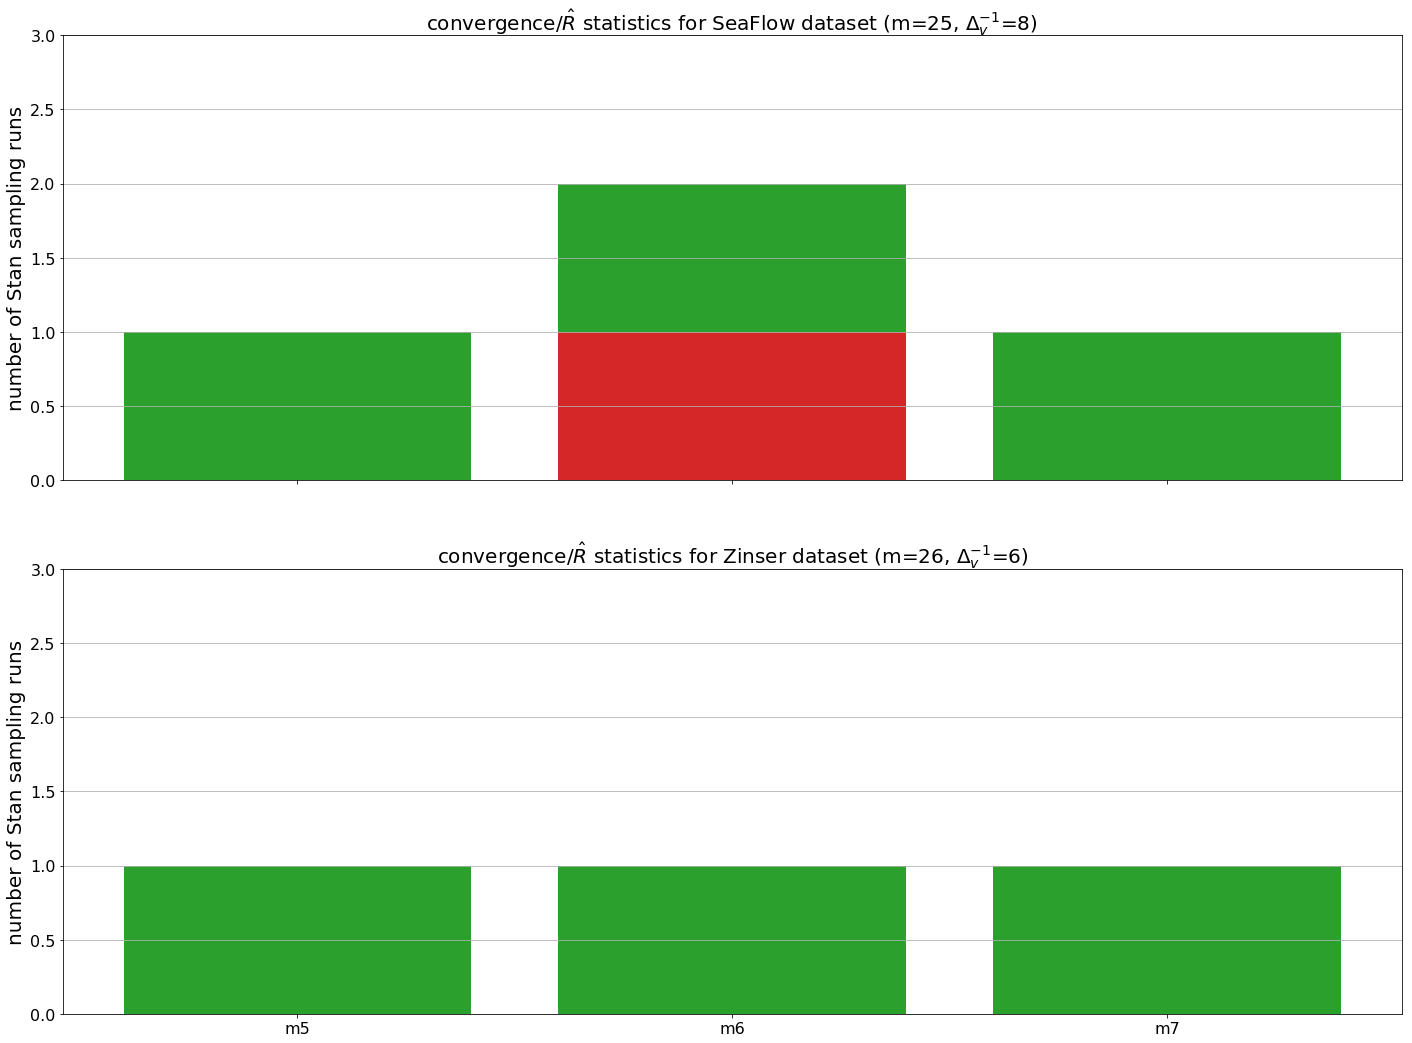

In [8]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')
'''
for dataname in data:
    fig, ax = plt.subplots(figsize=(16,9))
    ax.set_title('{} dataset'.format(dataname))
    for name in mcmcs:
        ax.scatter(maxrhats[name][dataname], sampling_time[name][dataname], label='{}'.format(desc_model[name]), s=120)

    ax.set(xlabel='max $\\hat{R}$', ylabel='runtime')
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend()
'''
None

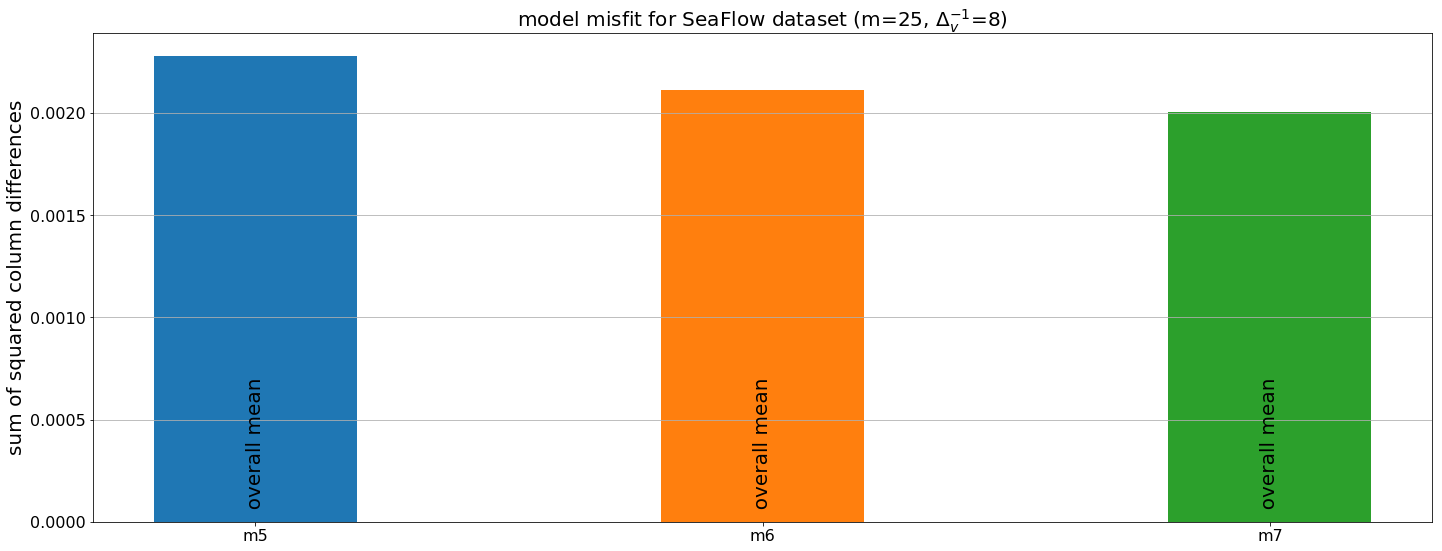

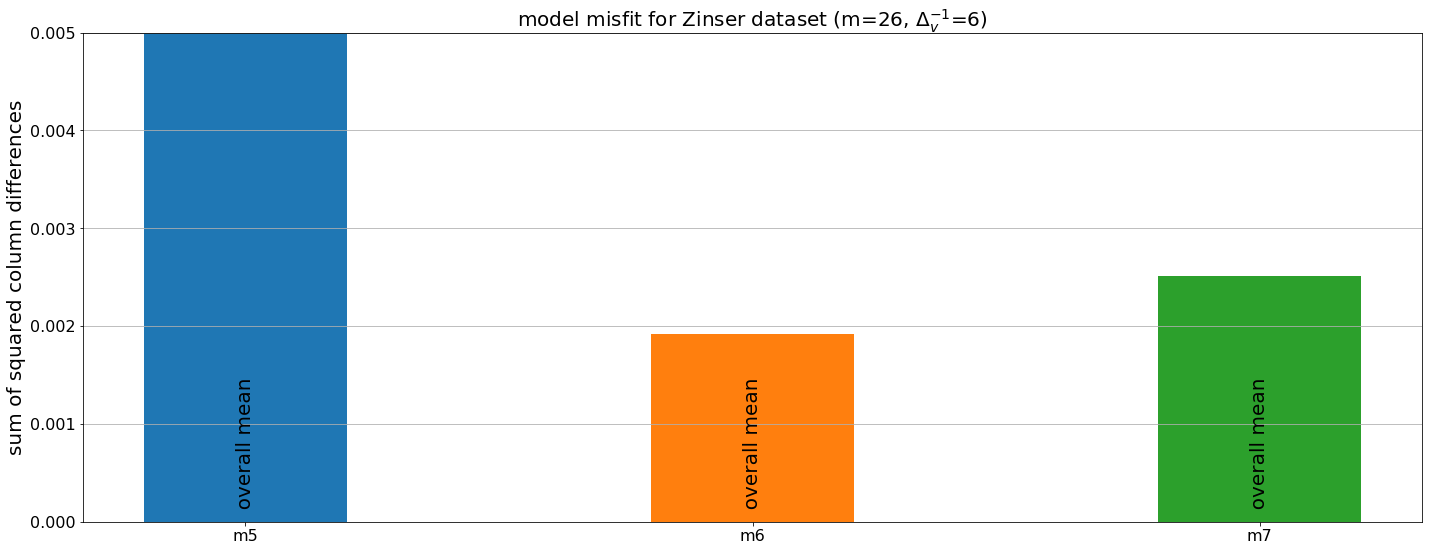

In [9]:
# updated code can handle all data[dataname]['i_test'] == 0 and draw only a single bar
if np.all(data[dataname]['i_test'] == 0):
    num_bars = 1
else:
    num_bars = 3

height = np.zeros(num_bars)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        if num_bars > 1:
            height[1] = np.mean(e[data[dataname]['i_test'] == 0])
            height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = (num_bars+1)*i+np.arange(num_bars)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[num_bars//3], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[num_bars//3])
        xticklabels.append(desc_model[name].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

## plot new cell volume-related output

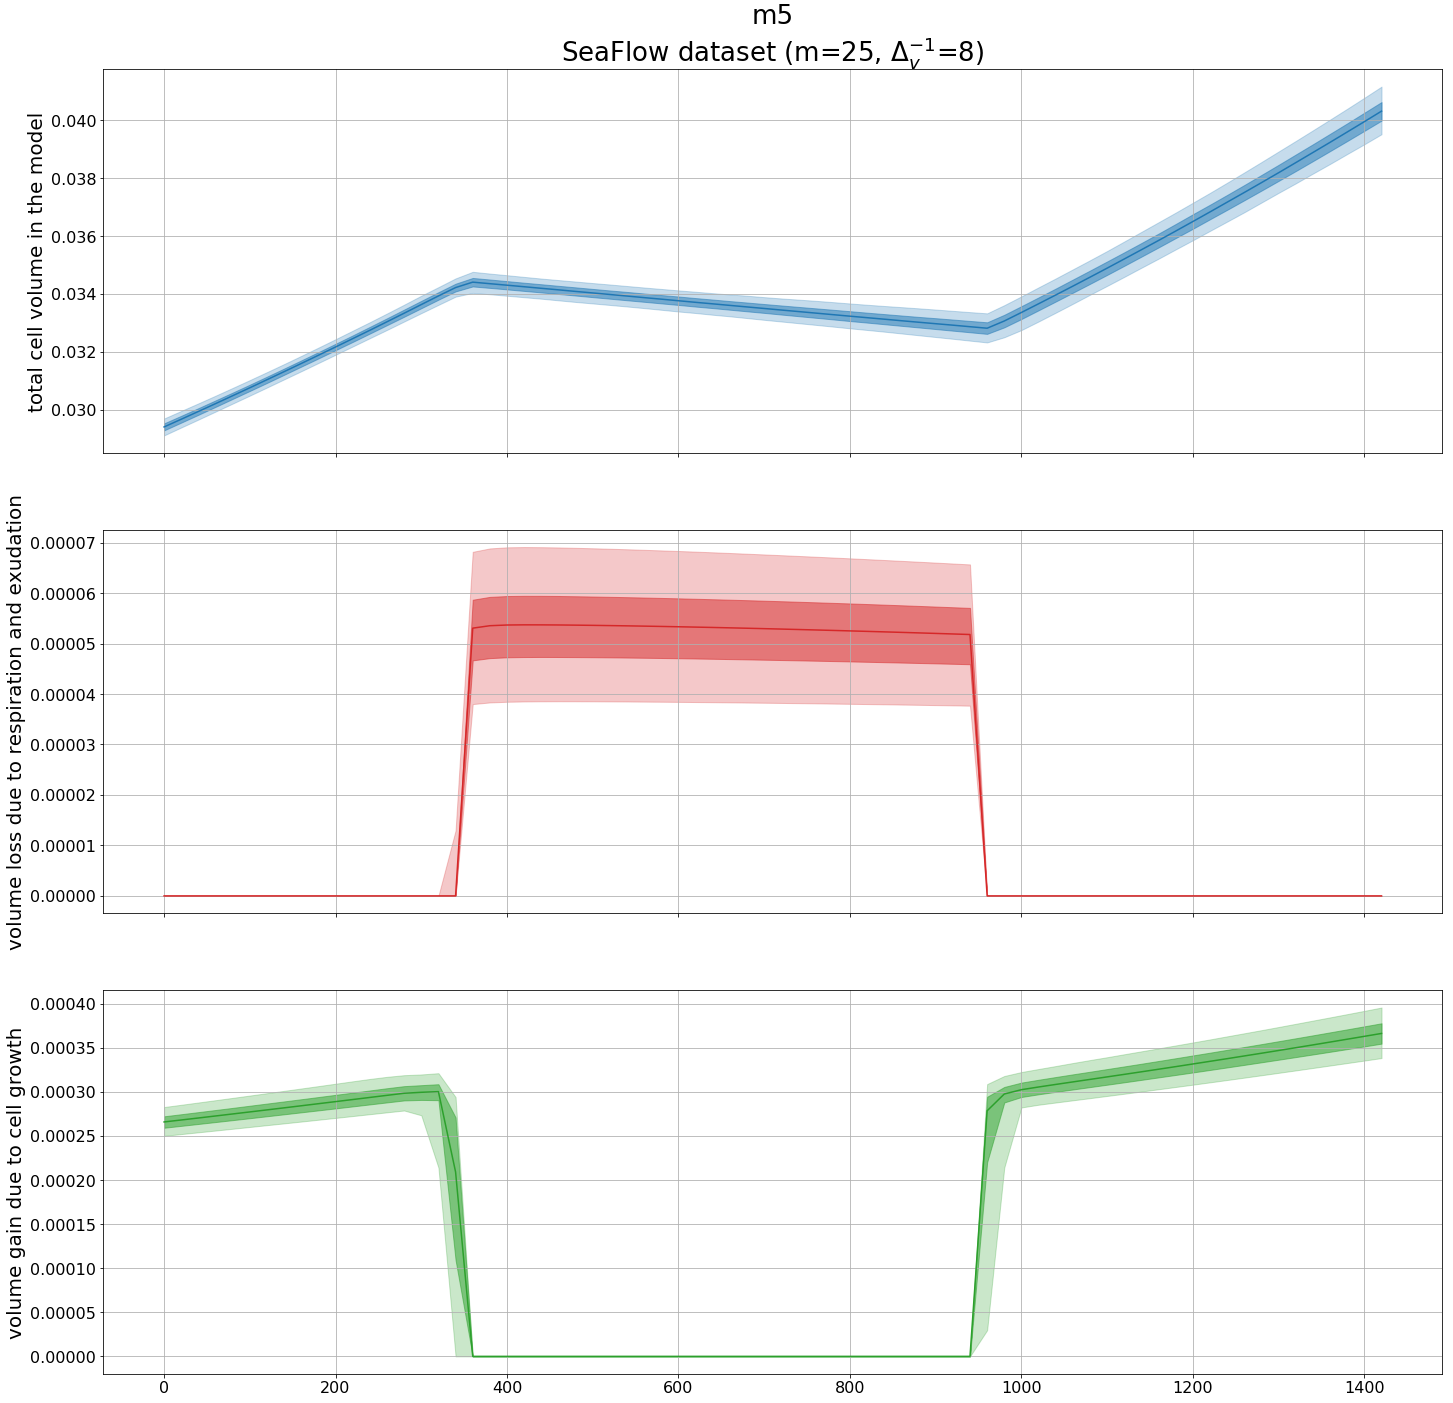

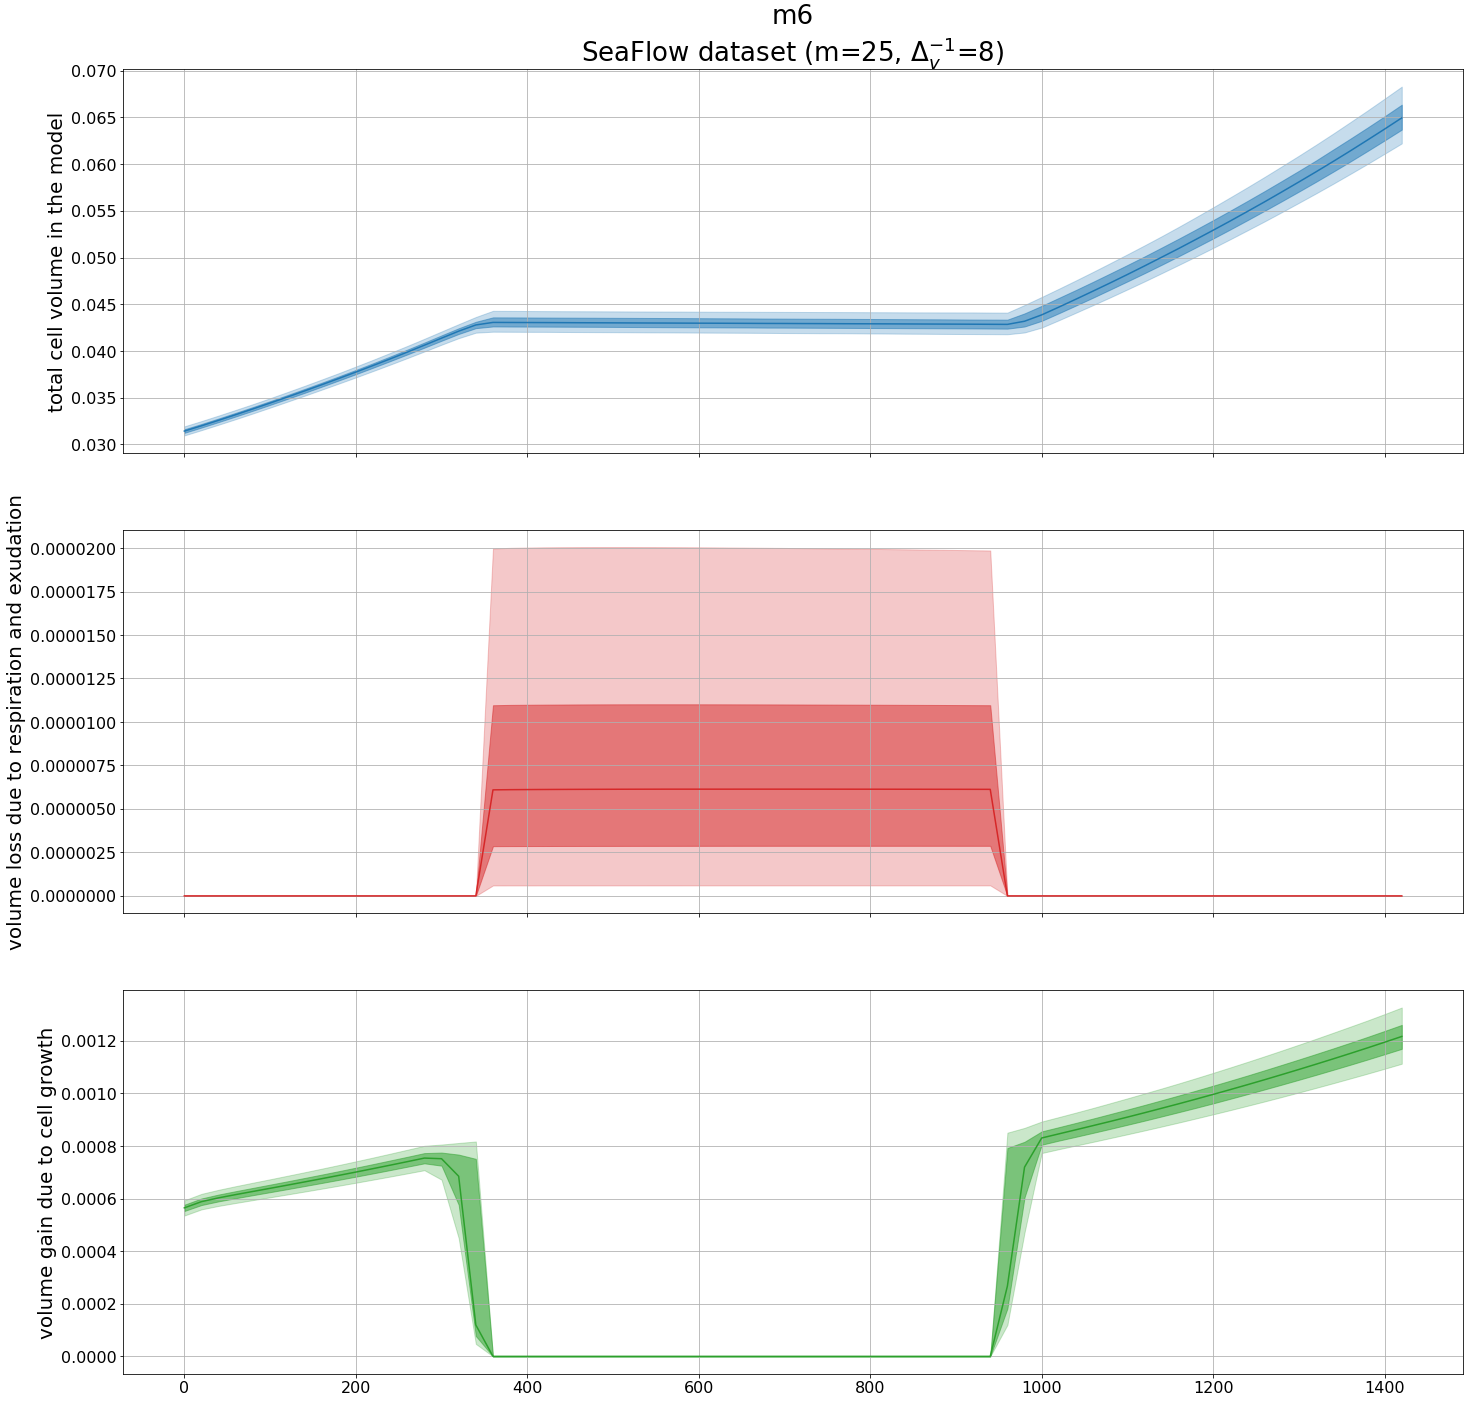

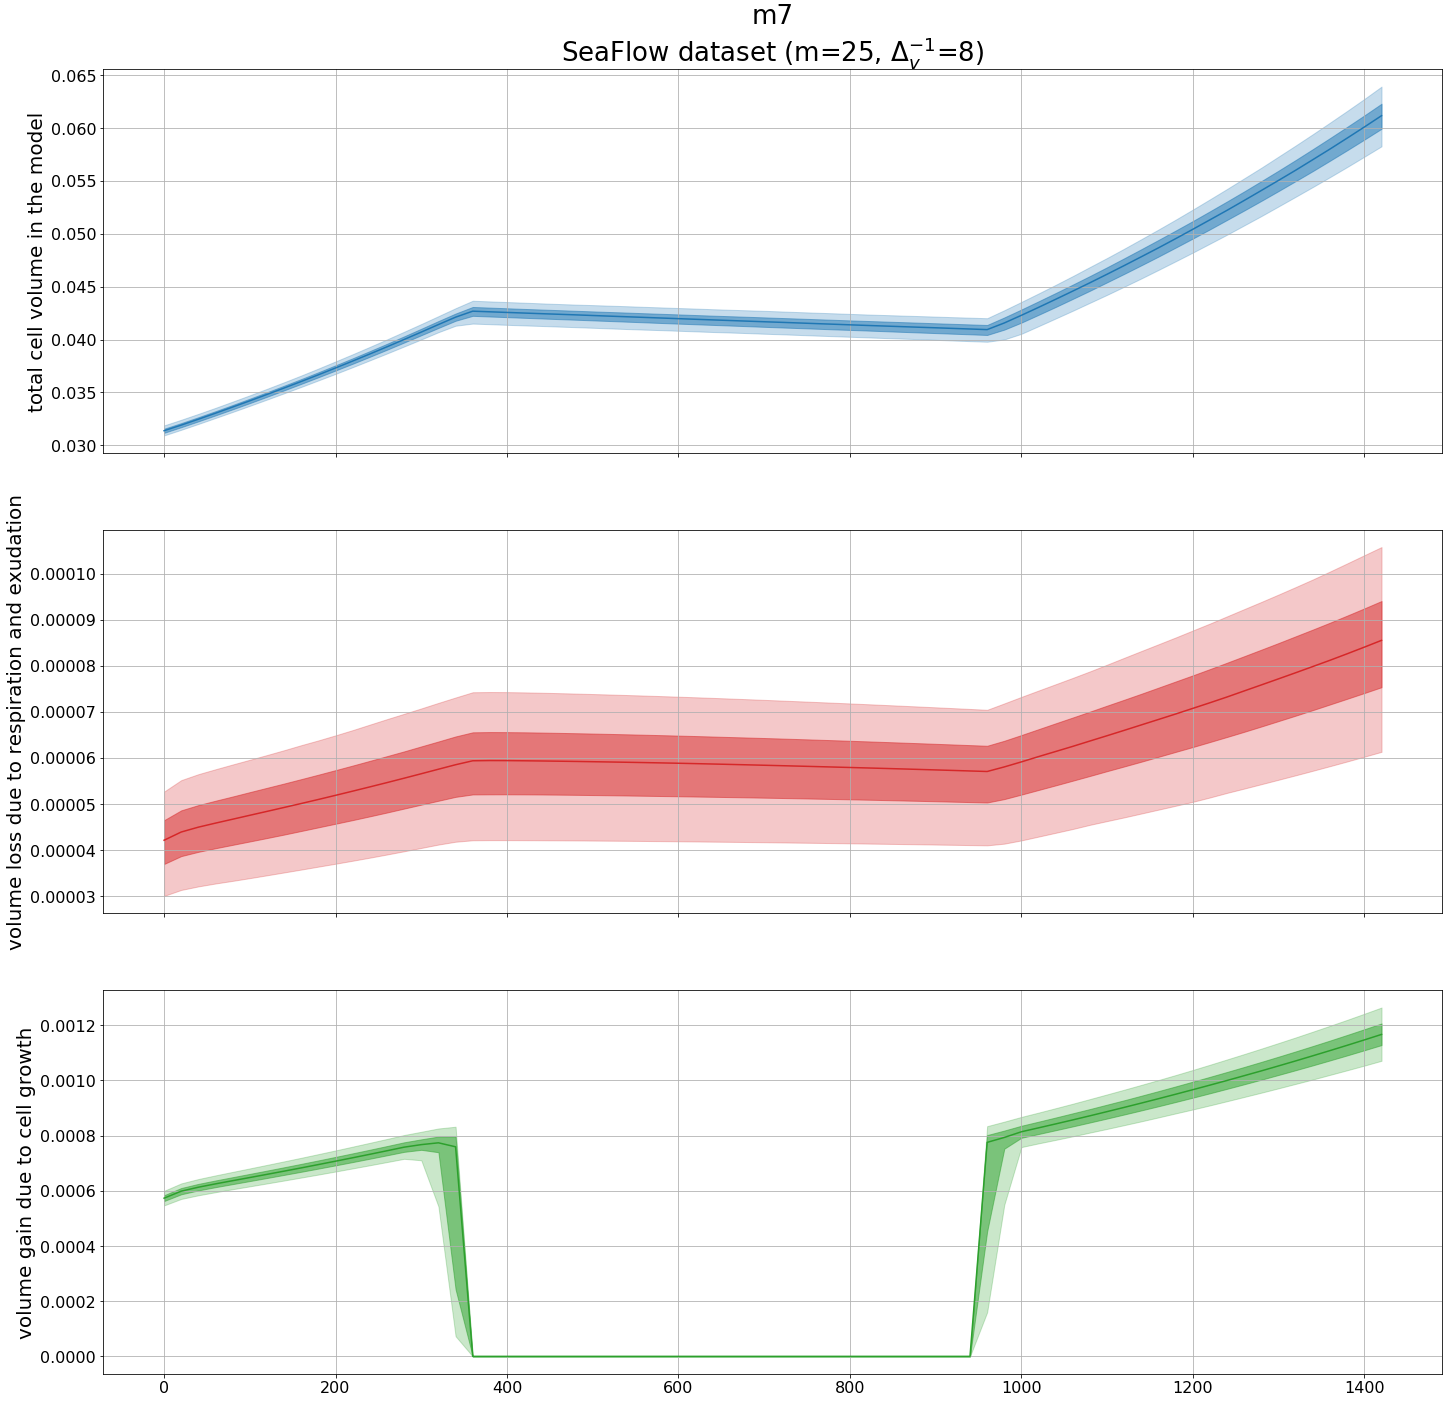

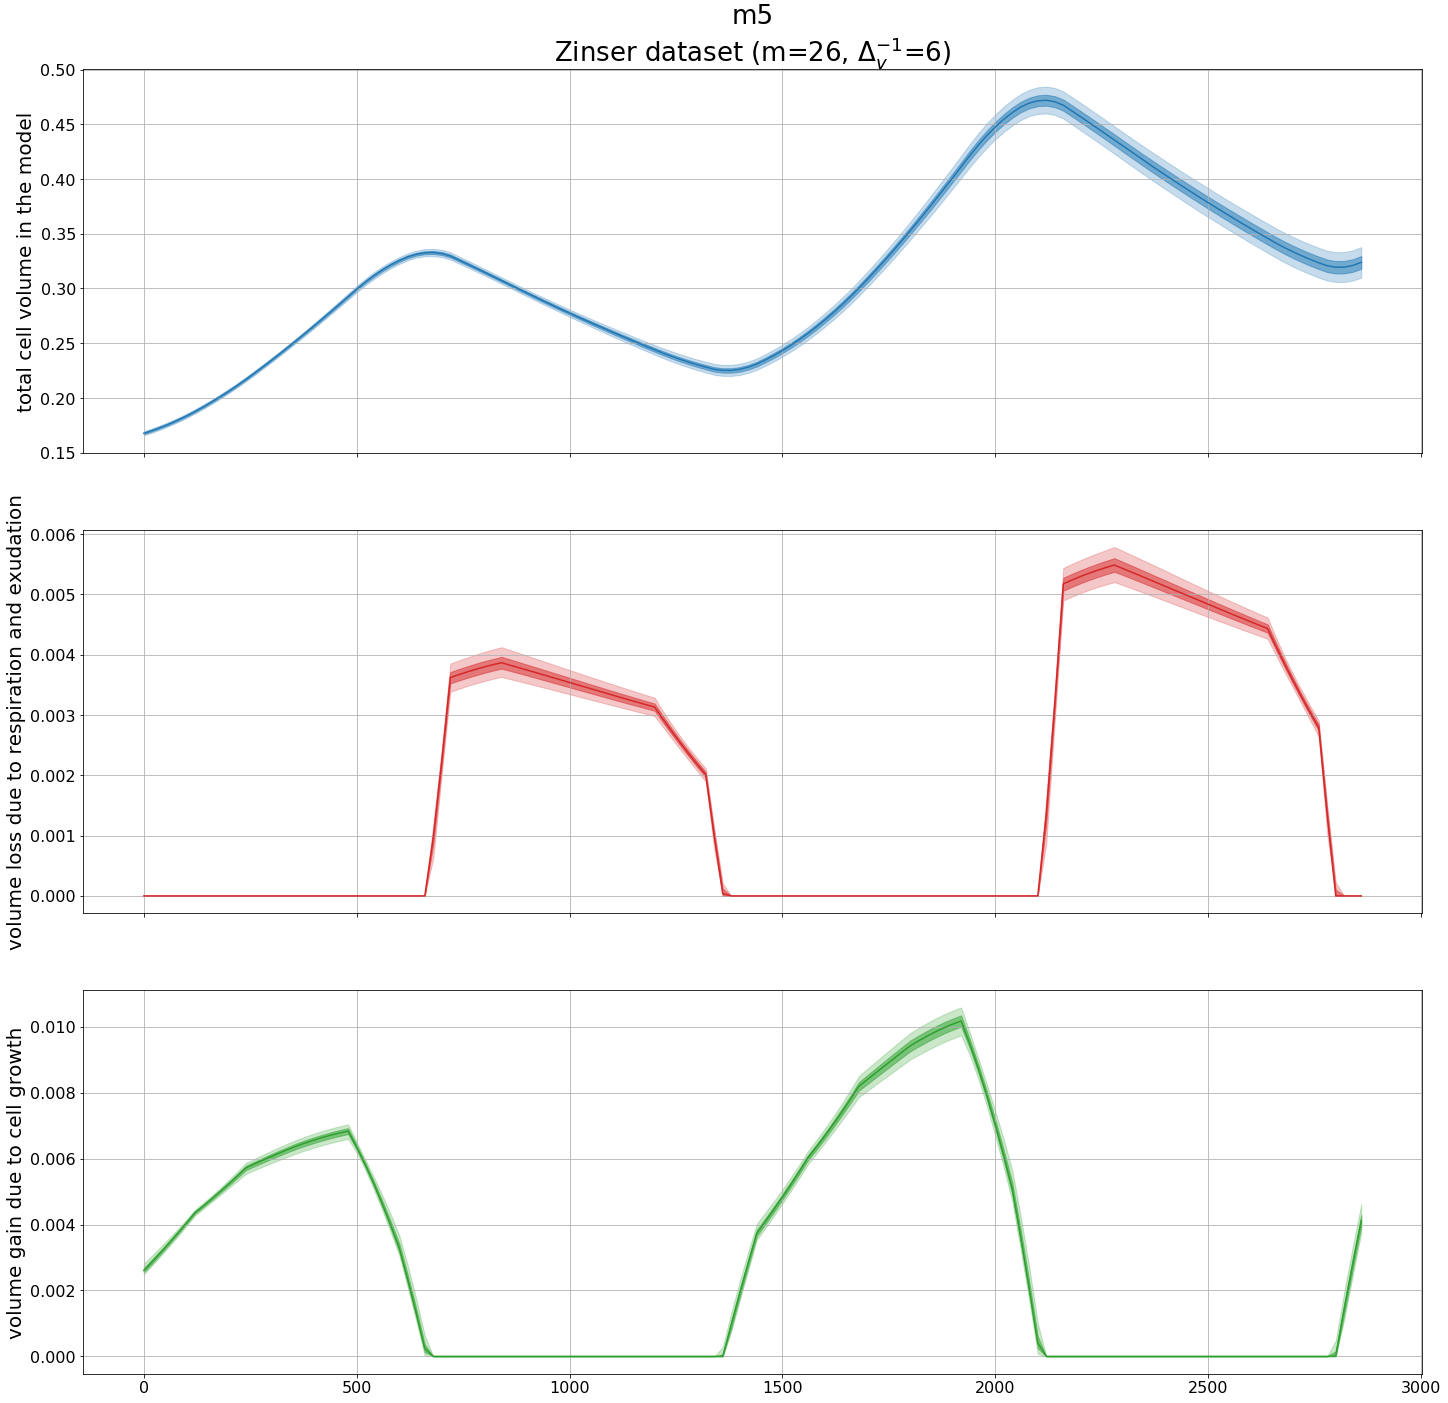

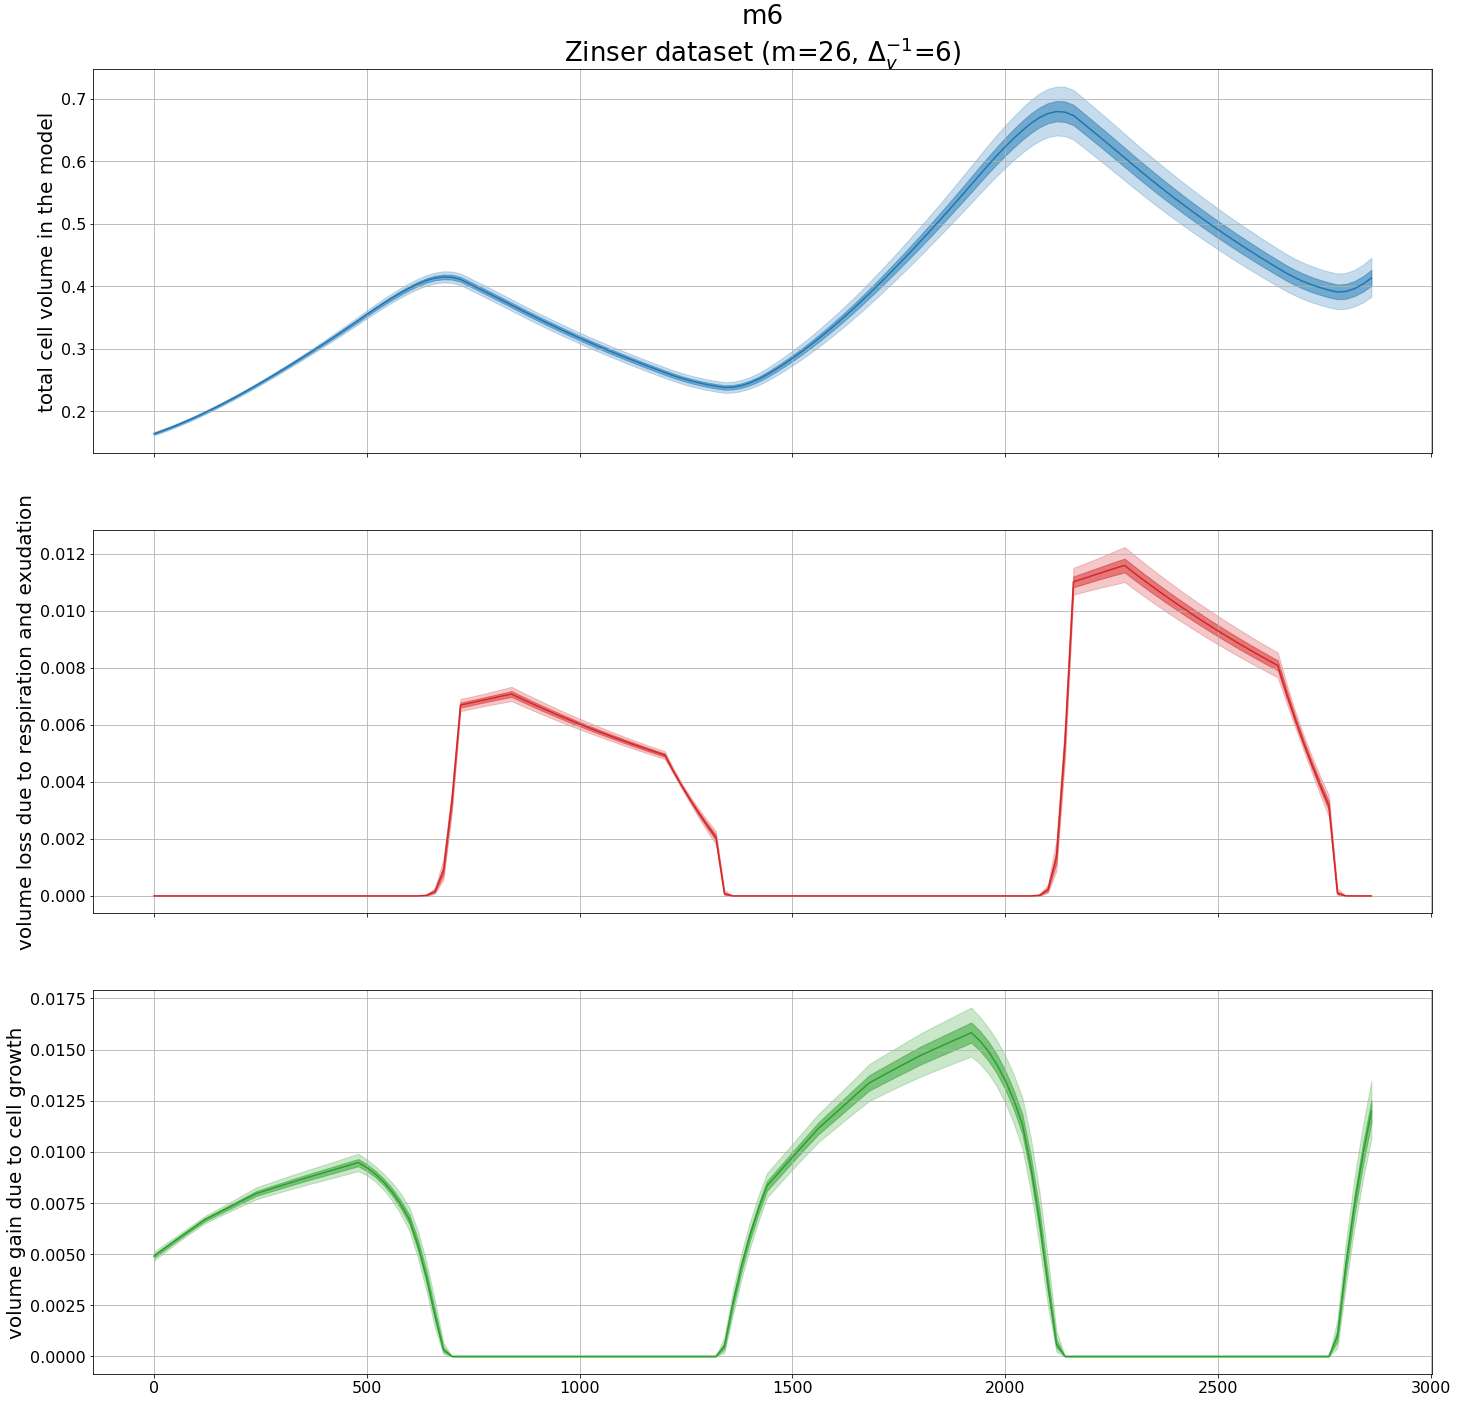

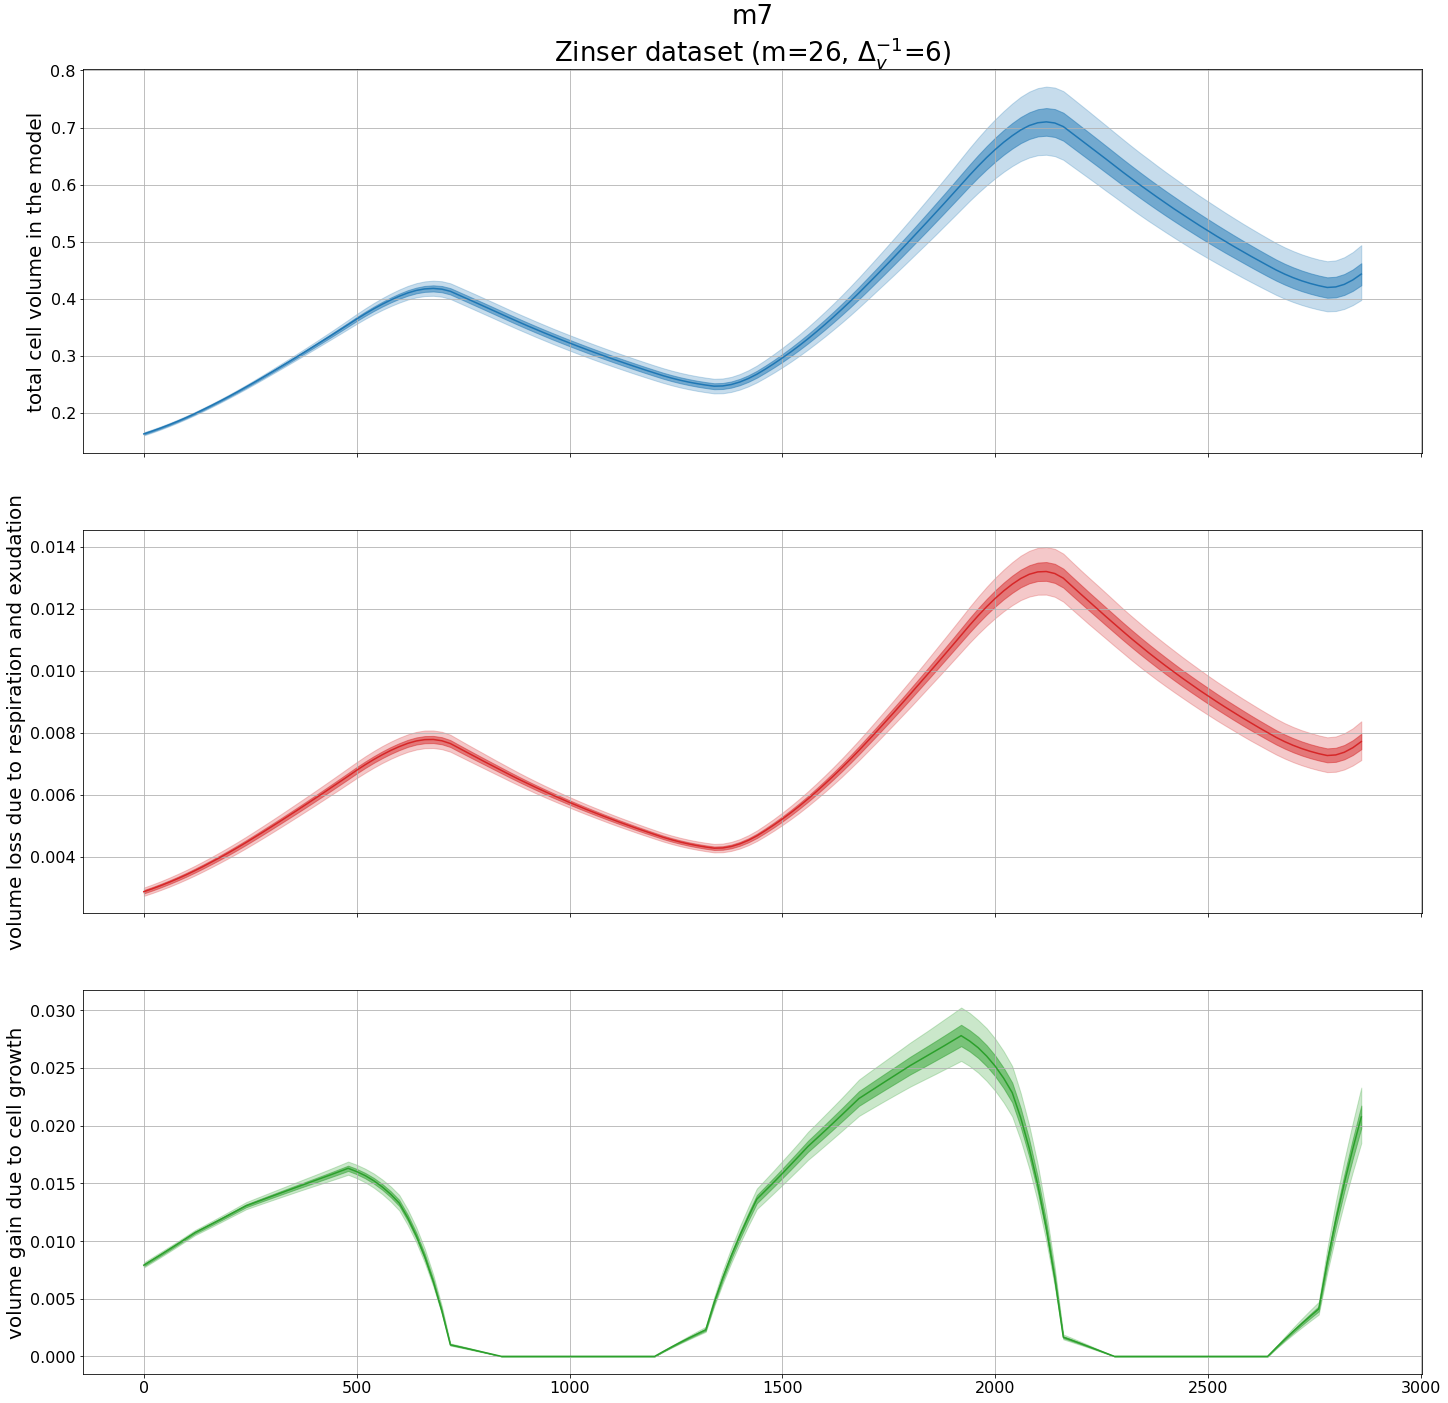

In [13]:
desc_var = {
    'total_vol':'total cell volume in the model',
    'resp_vol_loss':'volume loss due to respiration and exudation',
    'growth_vol_gain':'volume gain due to cell growth',
}
color_var = {
    'total_vol':'C0',
    'resp_vol_loss':'C3',
    'growth_vol_gain':'C2',
}

for dataname in data:
    
    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v_ext = v_min * 2**(np.arange(data[dataname]['m']+1)*delta_v)
    v_mid = 0.5*(v[1:]+v[:-1])
    
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    
    for name,mcmc in mcmcs.items():
        qq = {var:np.percentile(mcmc[dataname][var], q=(5,25,50,75,95), axis=0) for var in desc_var}
        
        nrows = len(qq)
        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(24,8*nrows))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        for var,ax in zip(qq,axs.flat):
            ax.fill_between(t, qq[var][0,:], qq[var][-1,:], alpha=0.25, color=color_var[var])
            ax.fill_between(t, qq[var][1,:], qq[var][-2,:], alpha=0.5, color=color_var[var])
            ax.plot(t, qq[var][2,:], color=color_var[var])
            ax.grid(True)
            ax.set_ylabel(desc_var[var])
        

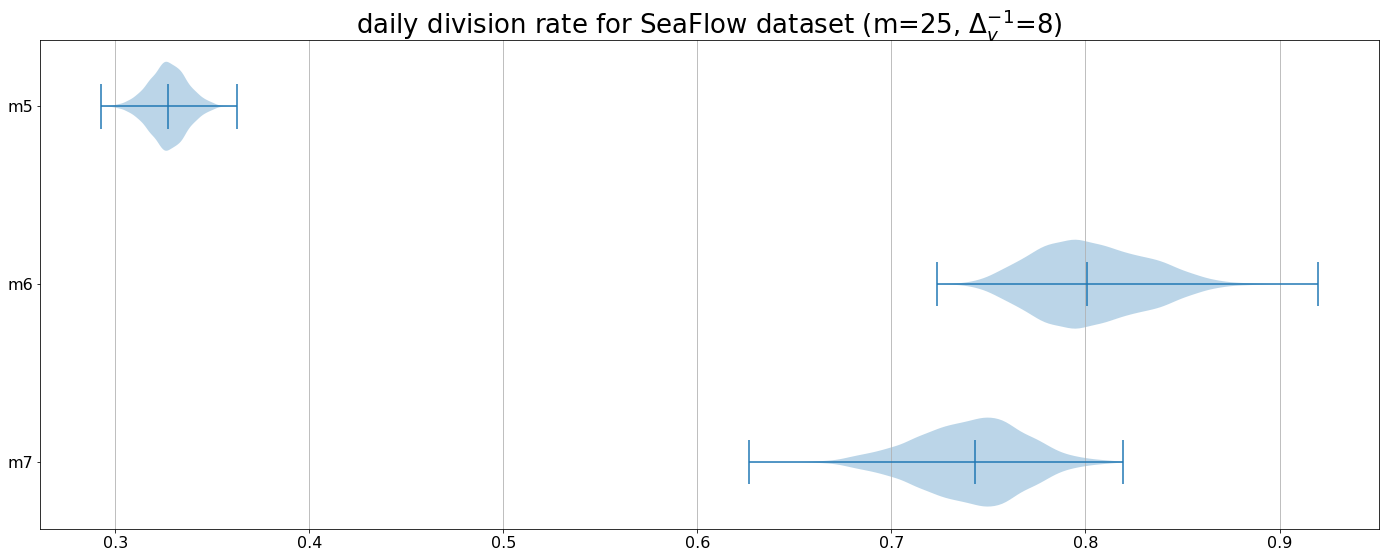

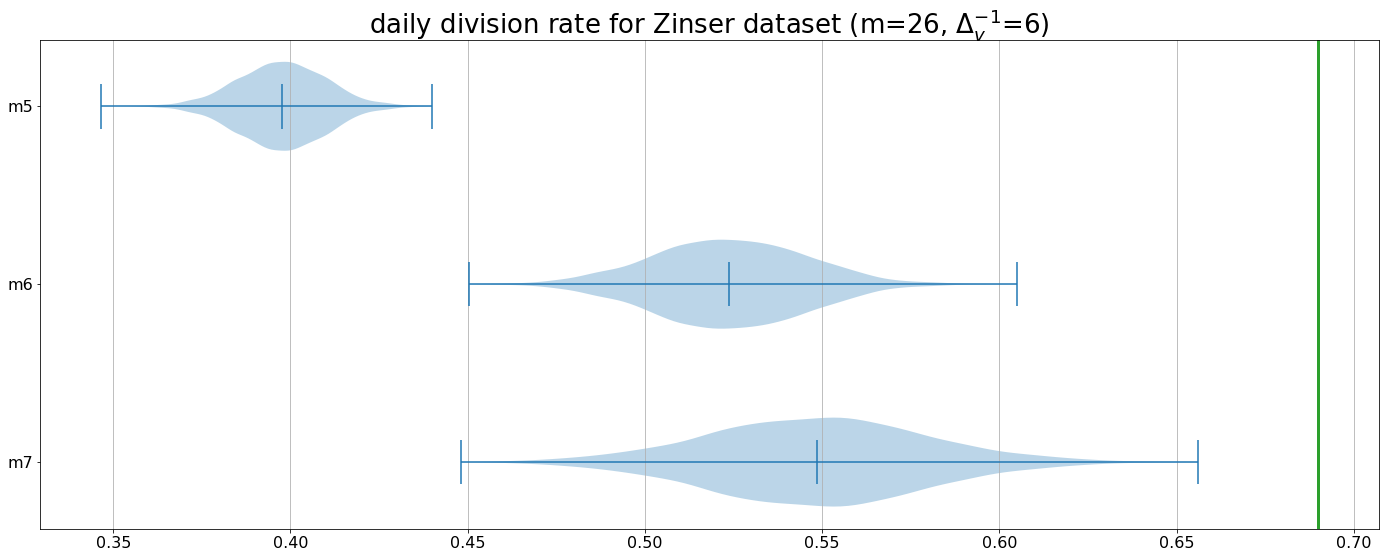

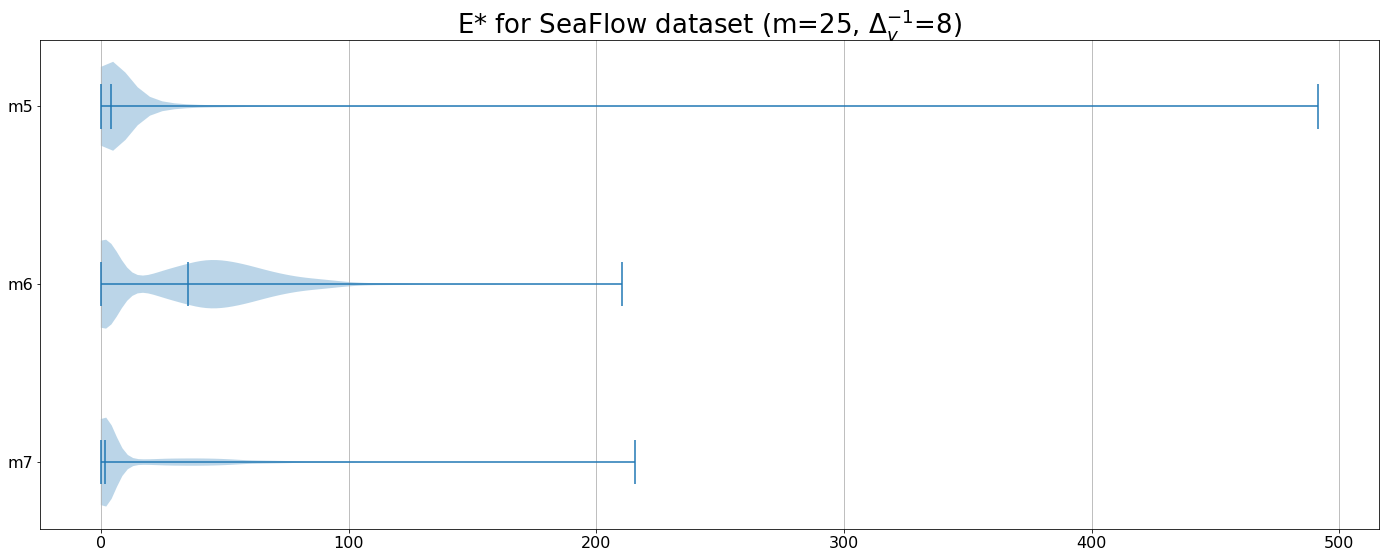

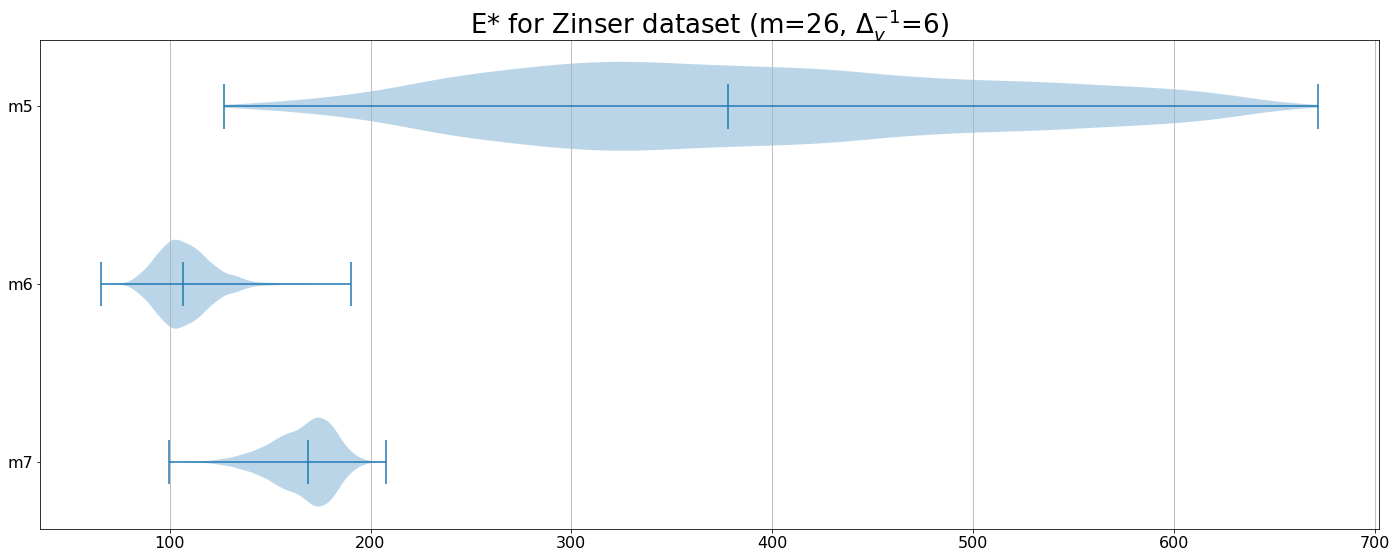

In [10]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[name][dataname][param] for name in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,name in enumerate(mcmcs):
            if maxrhats_final[name][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

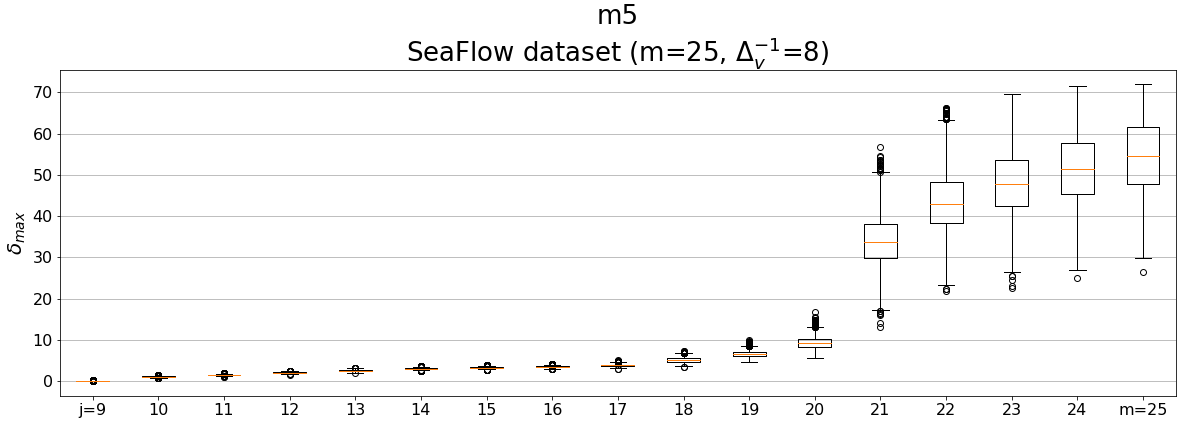

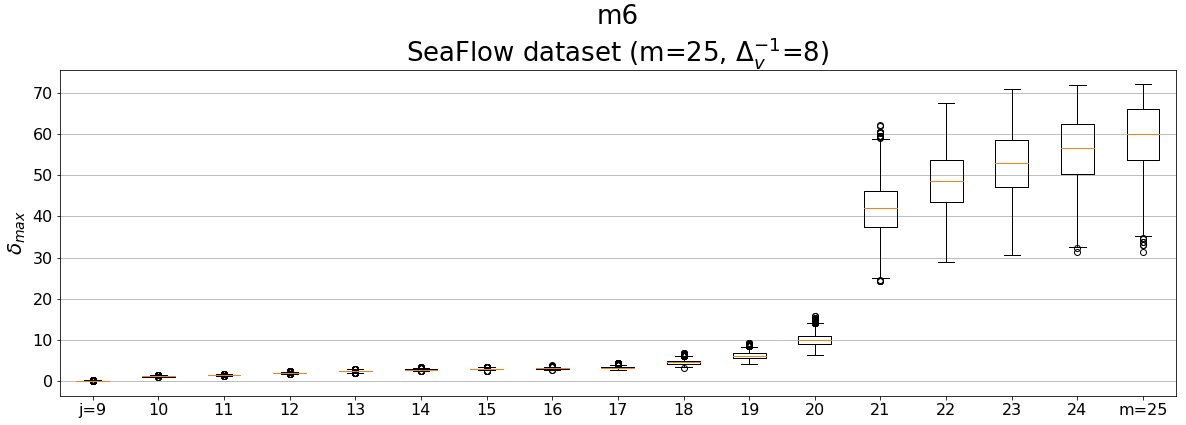

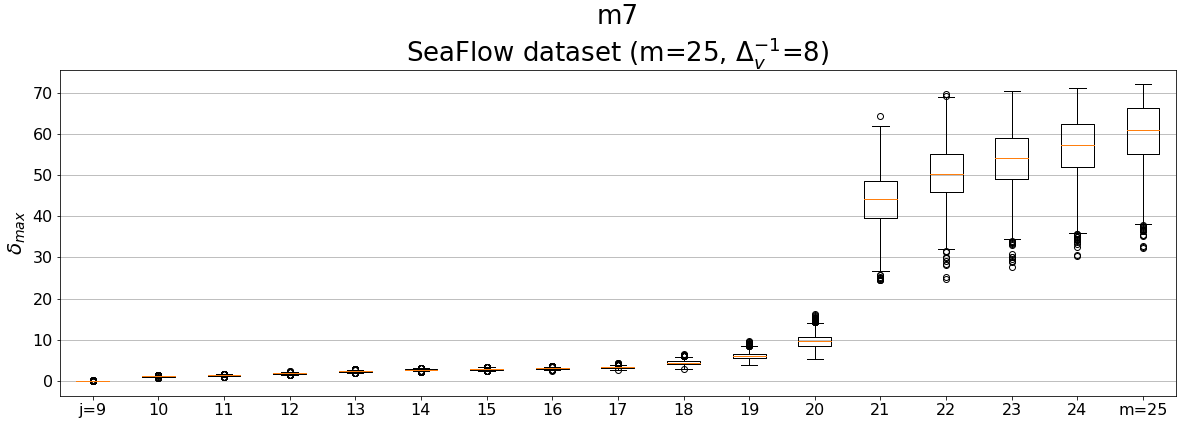

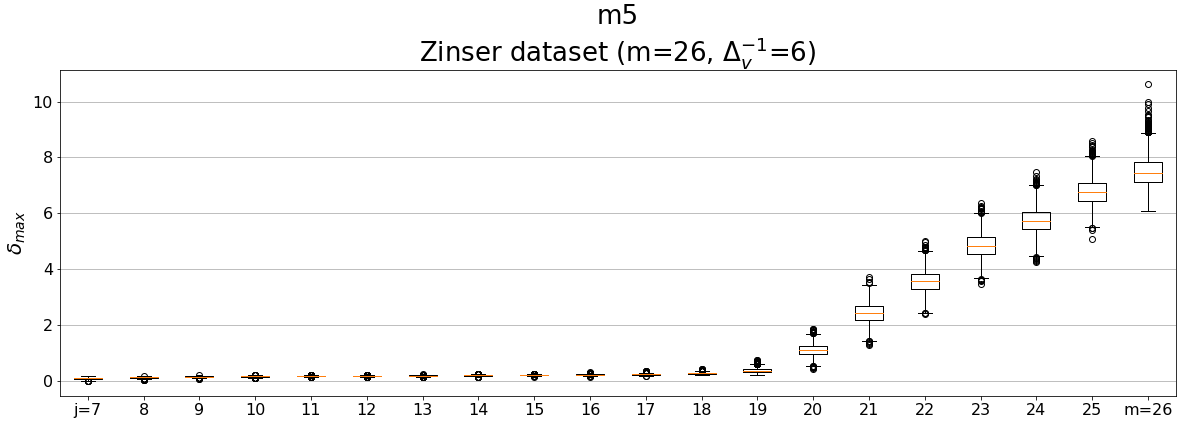

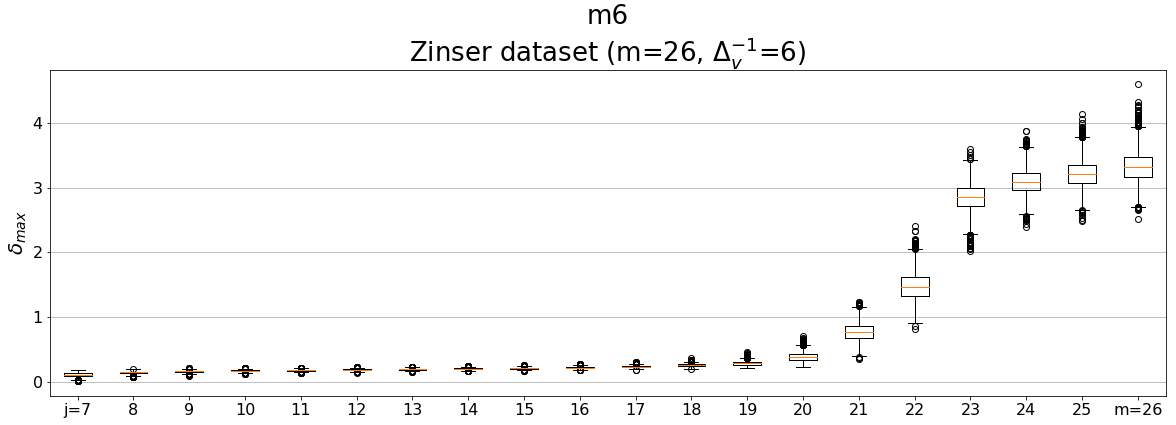

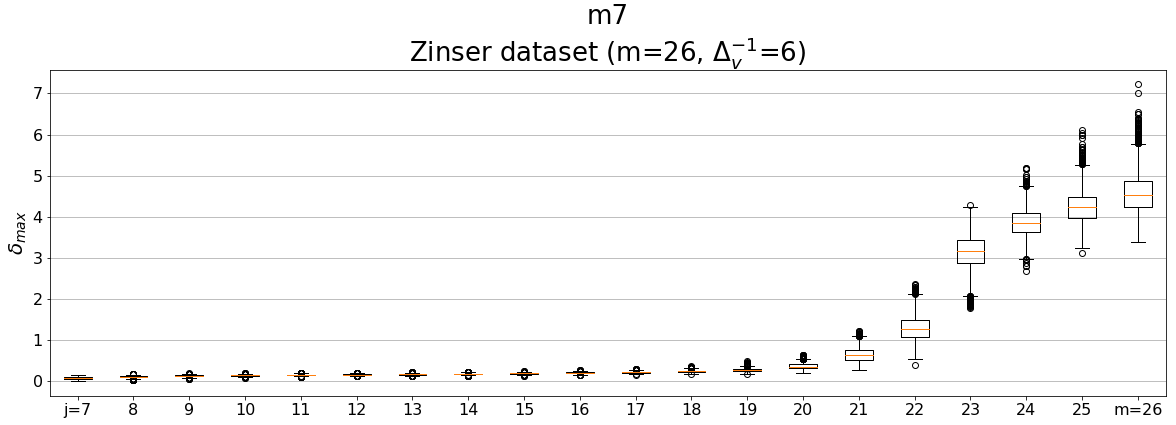

In [11]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

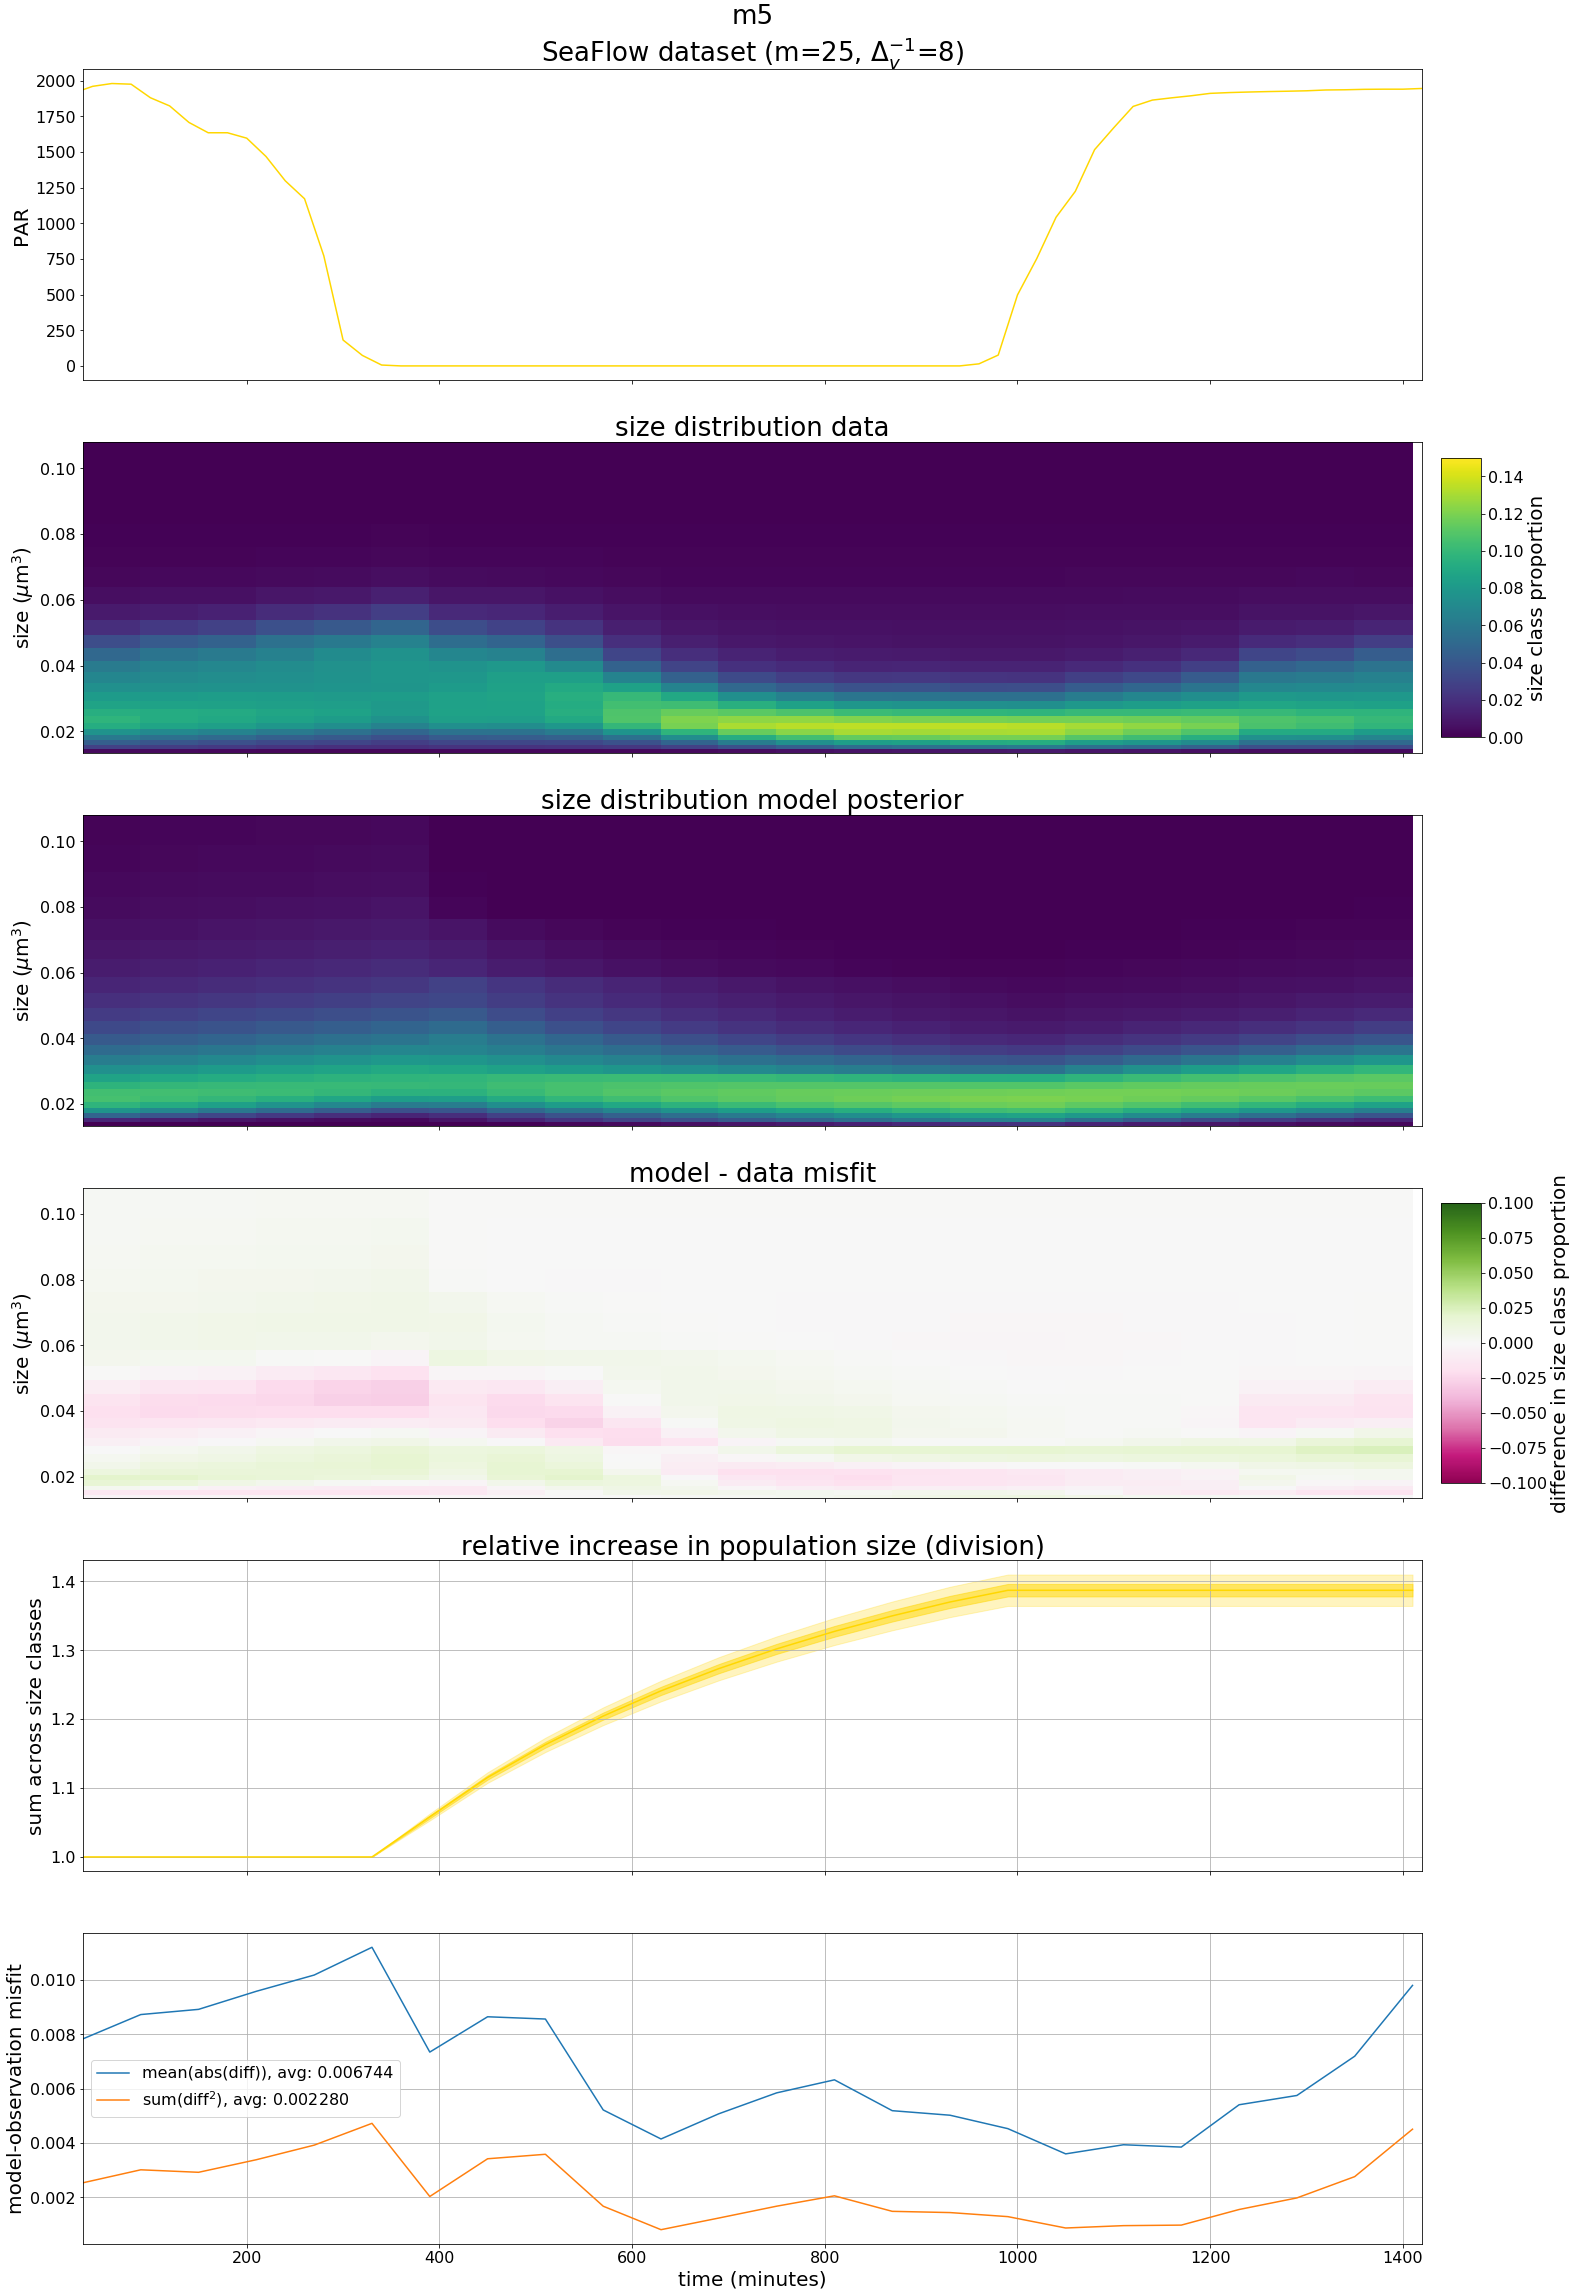

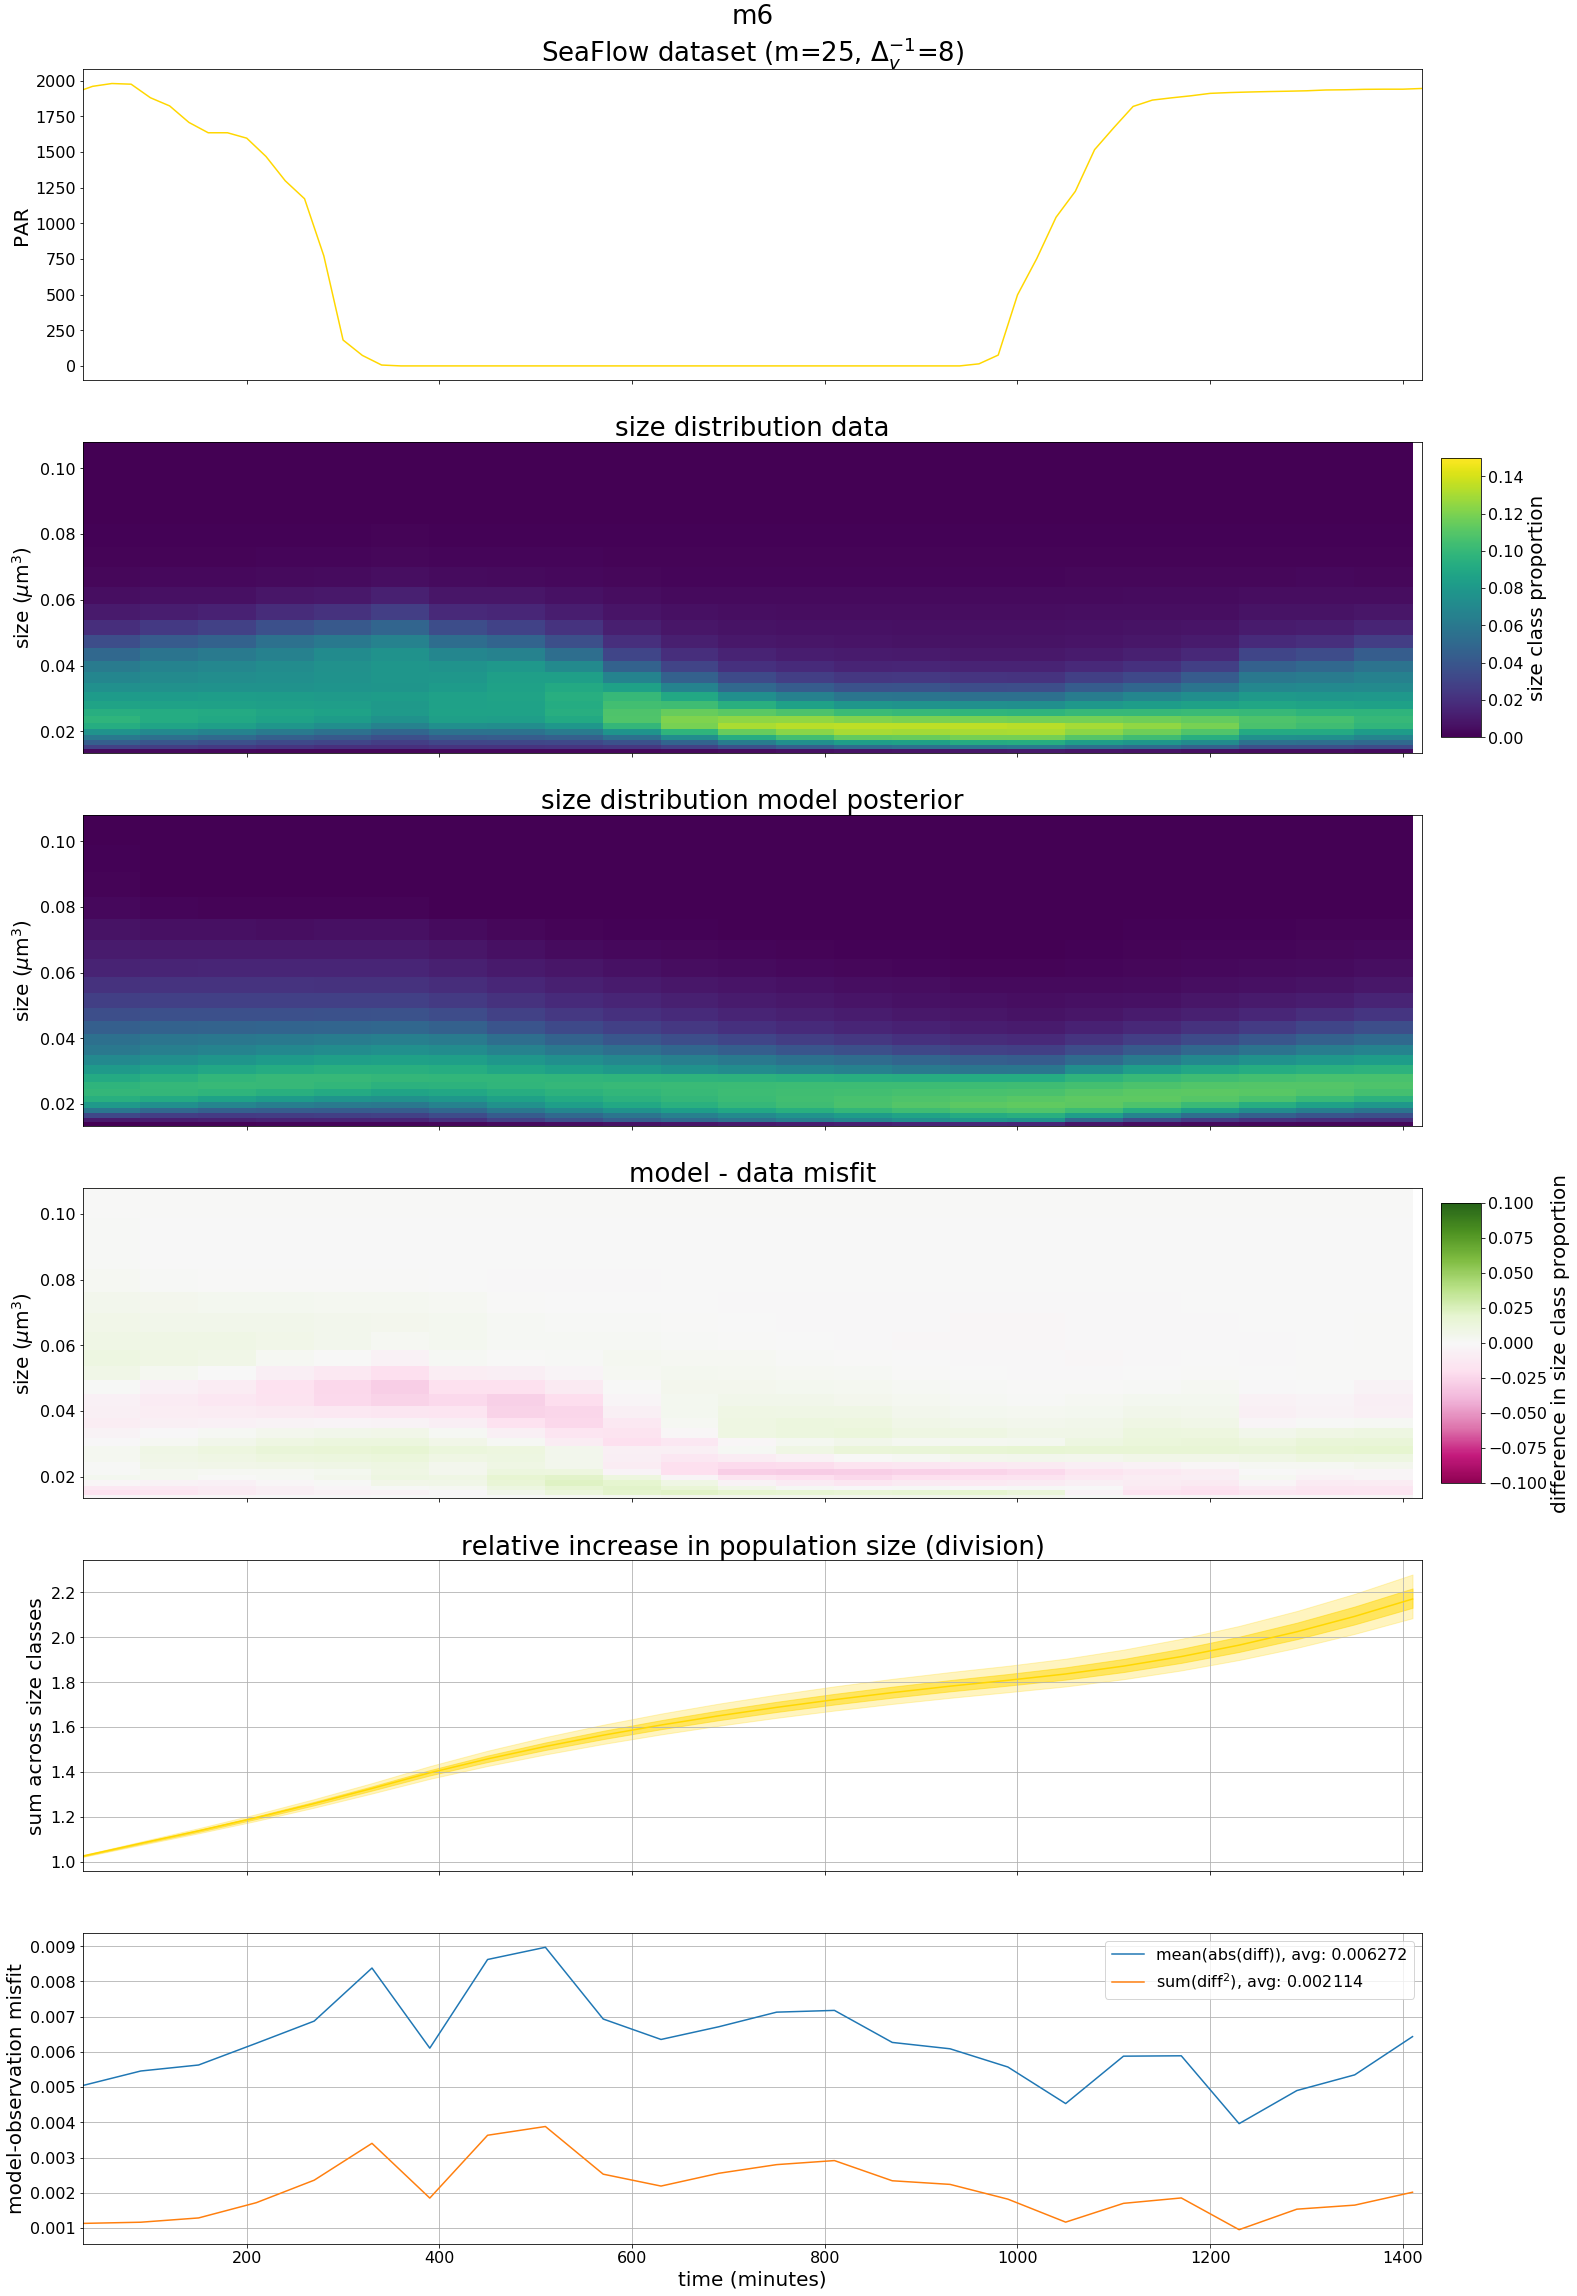

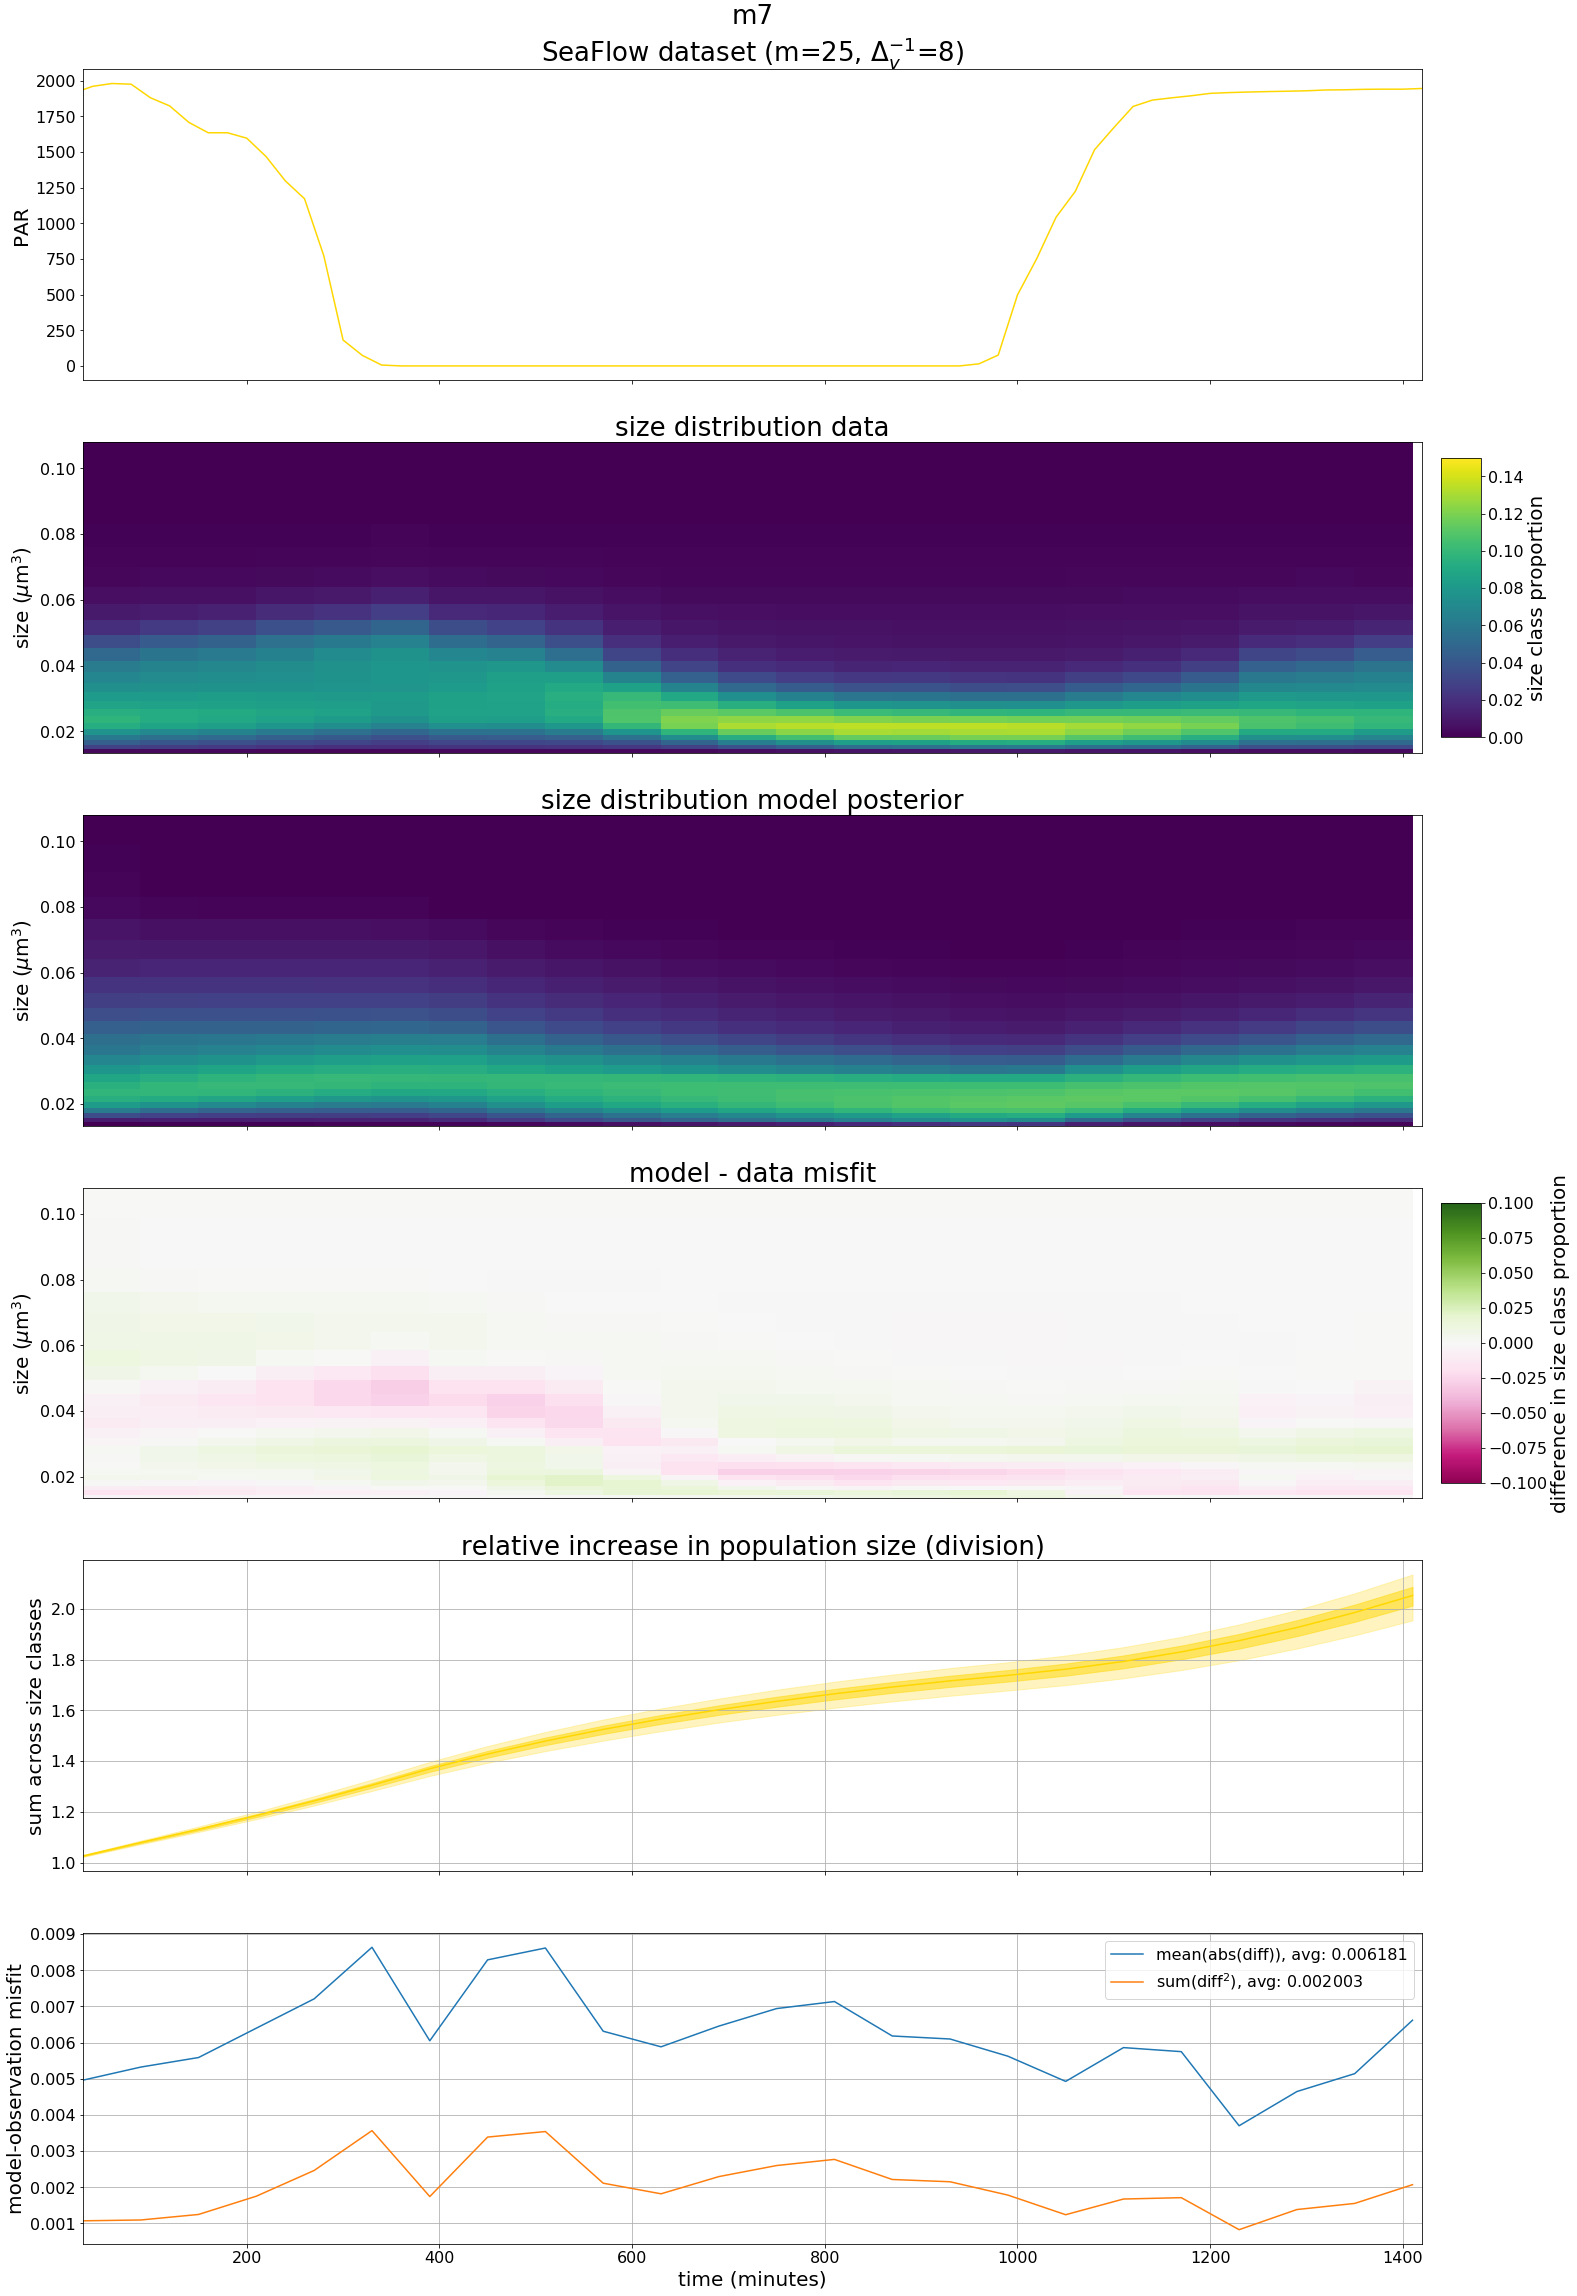

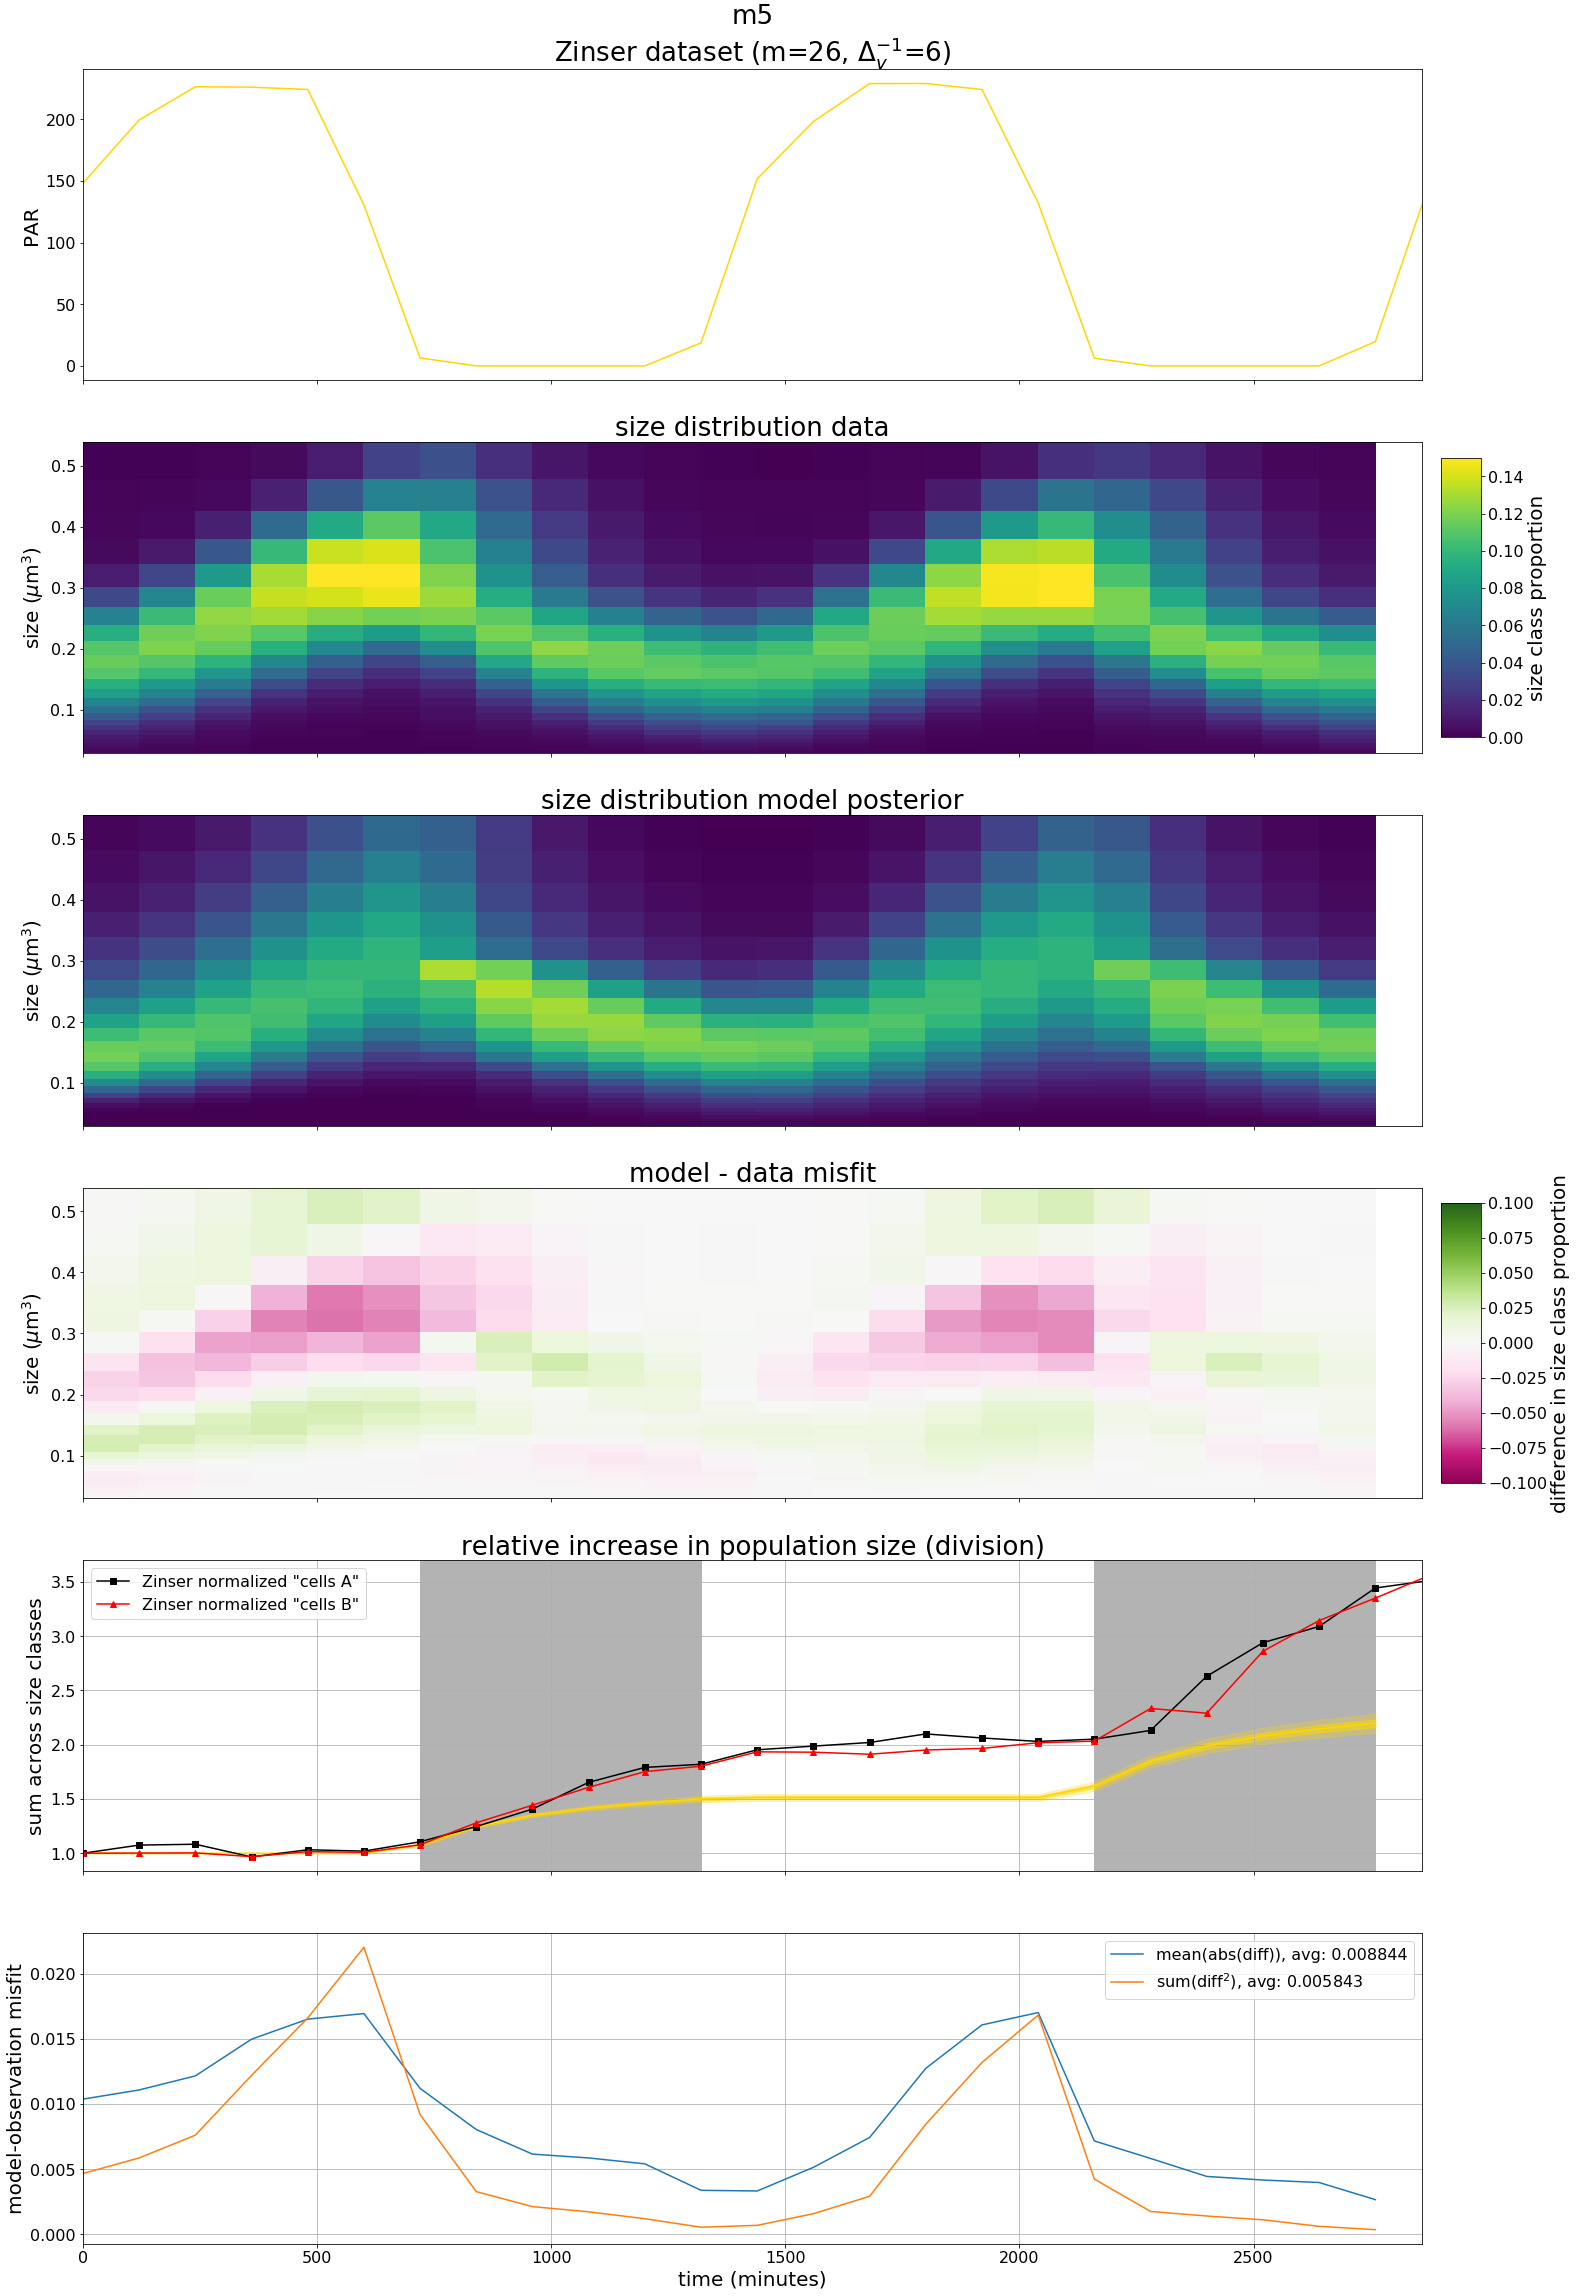

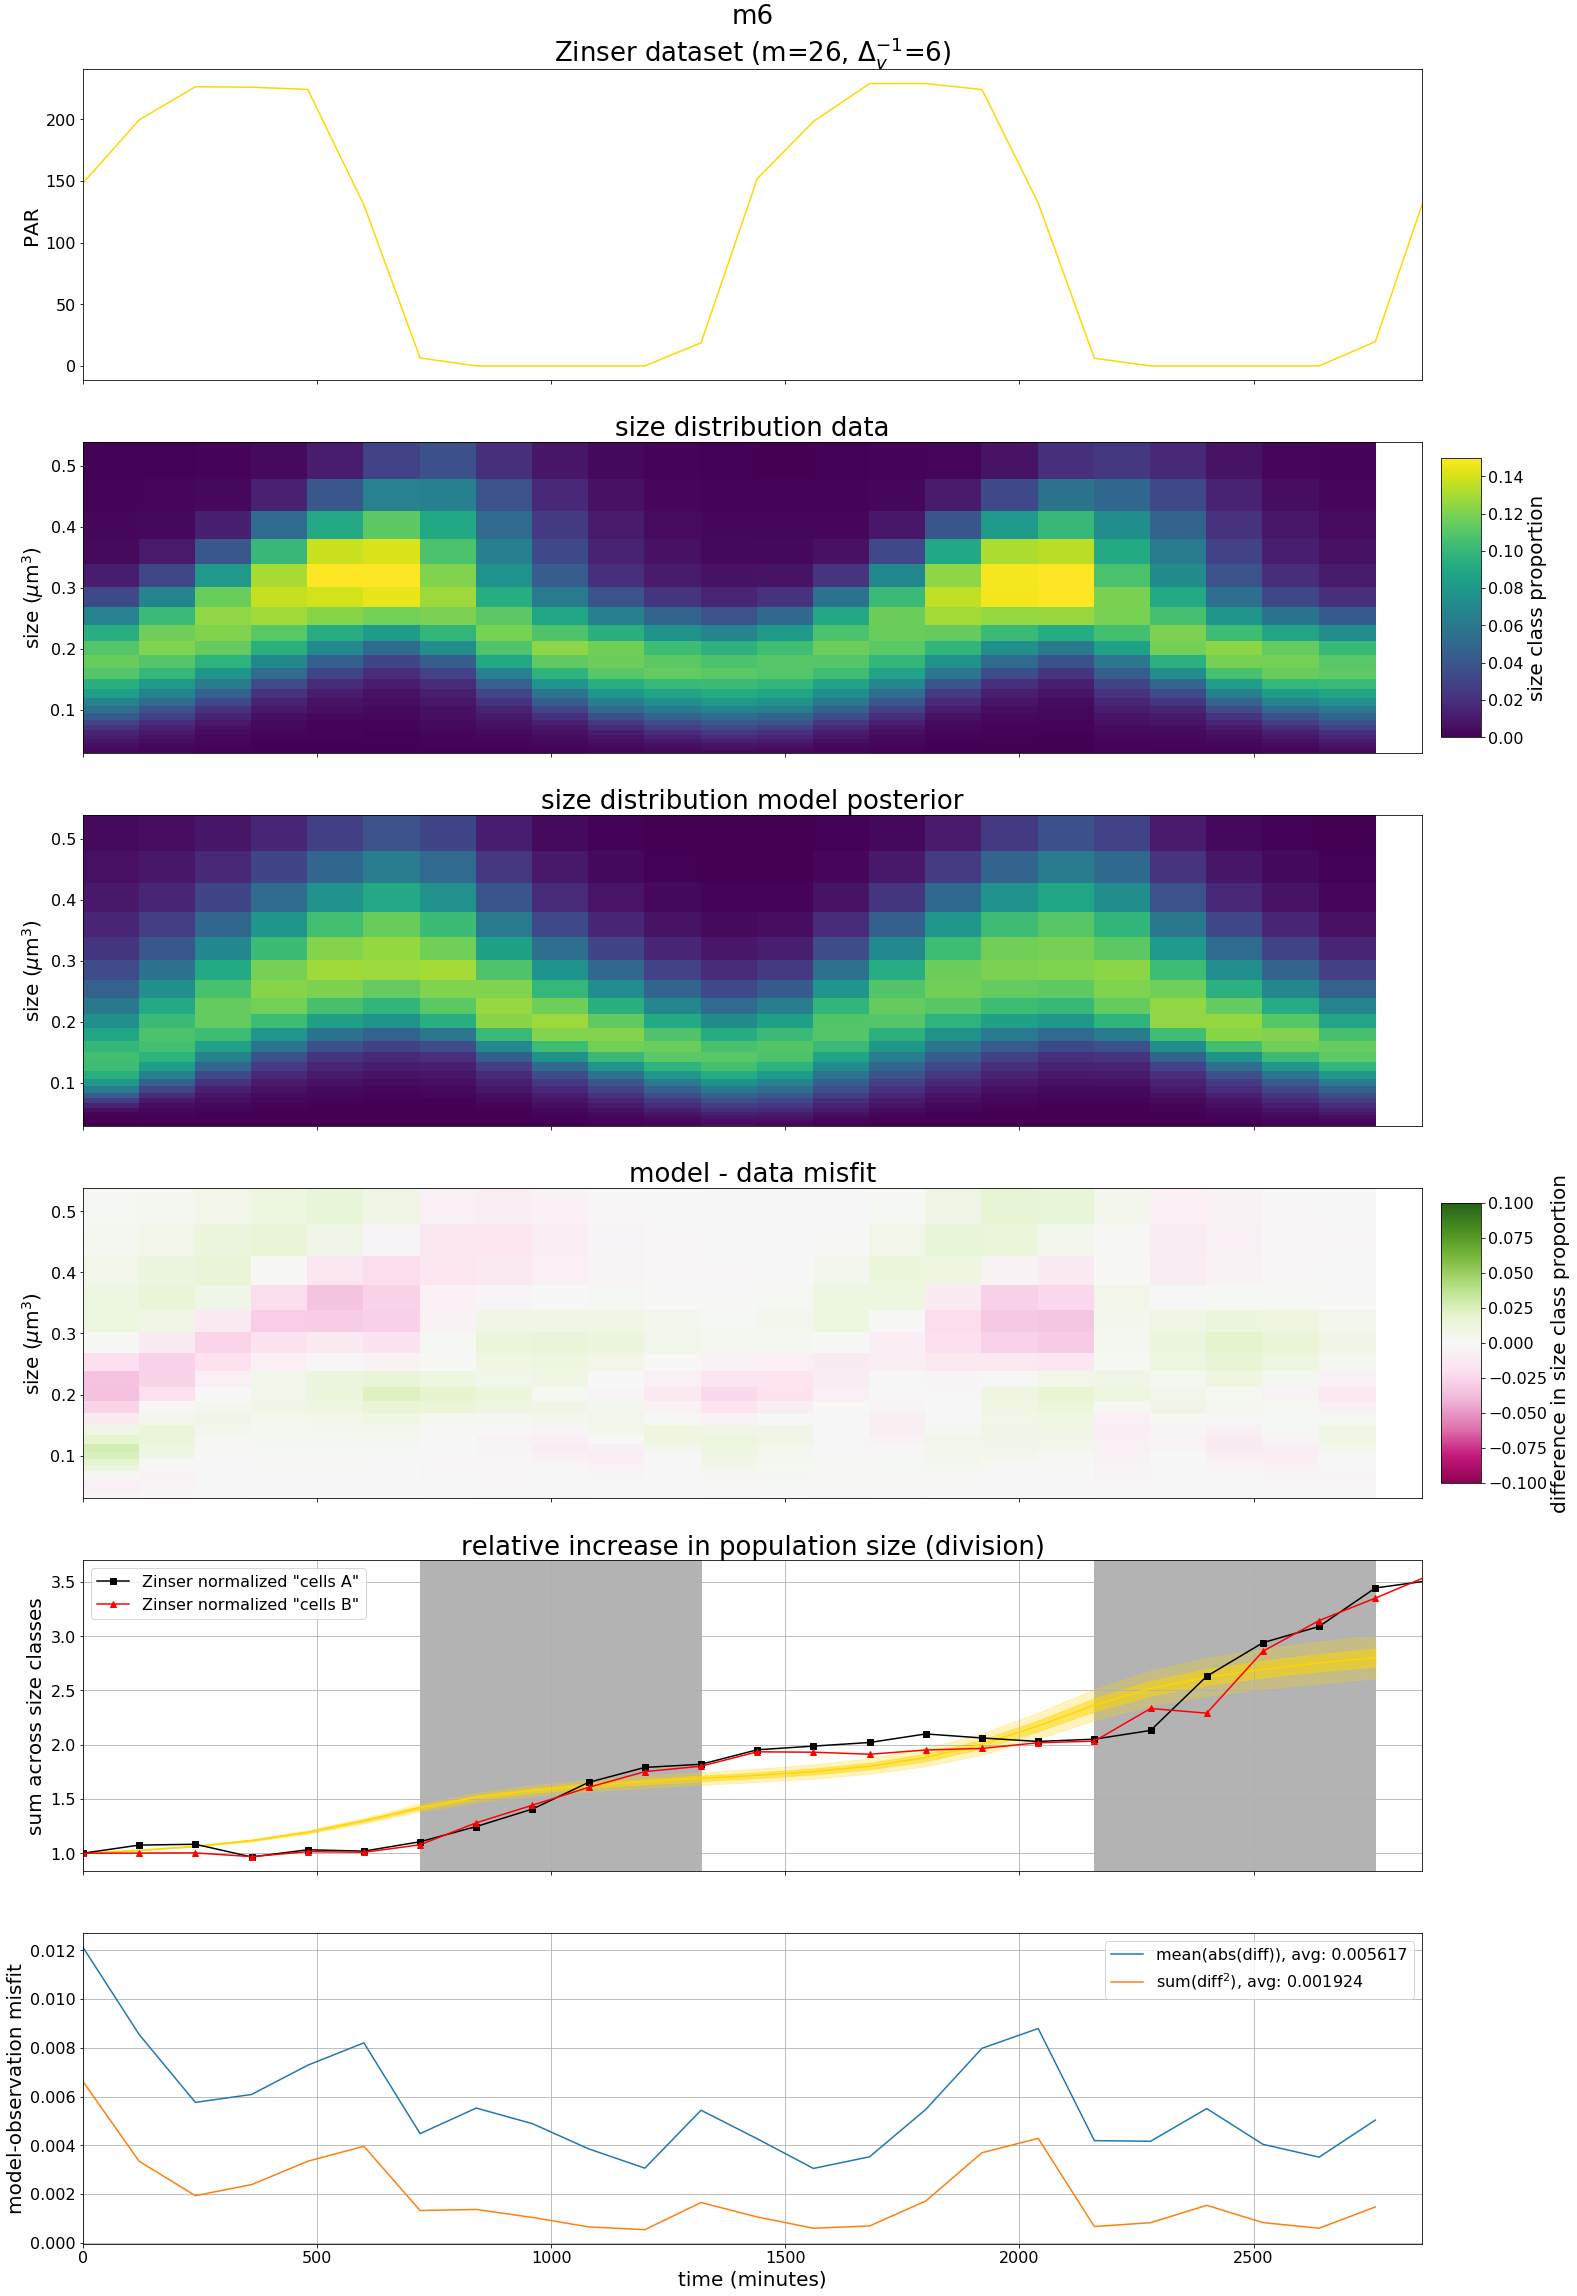

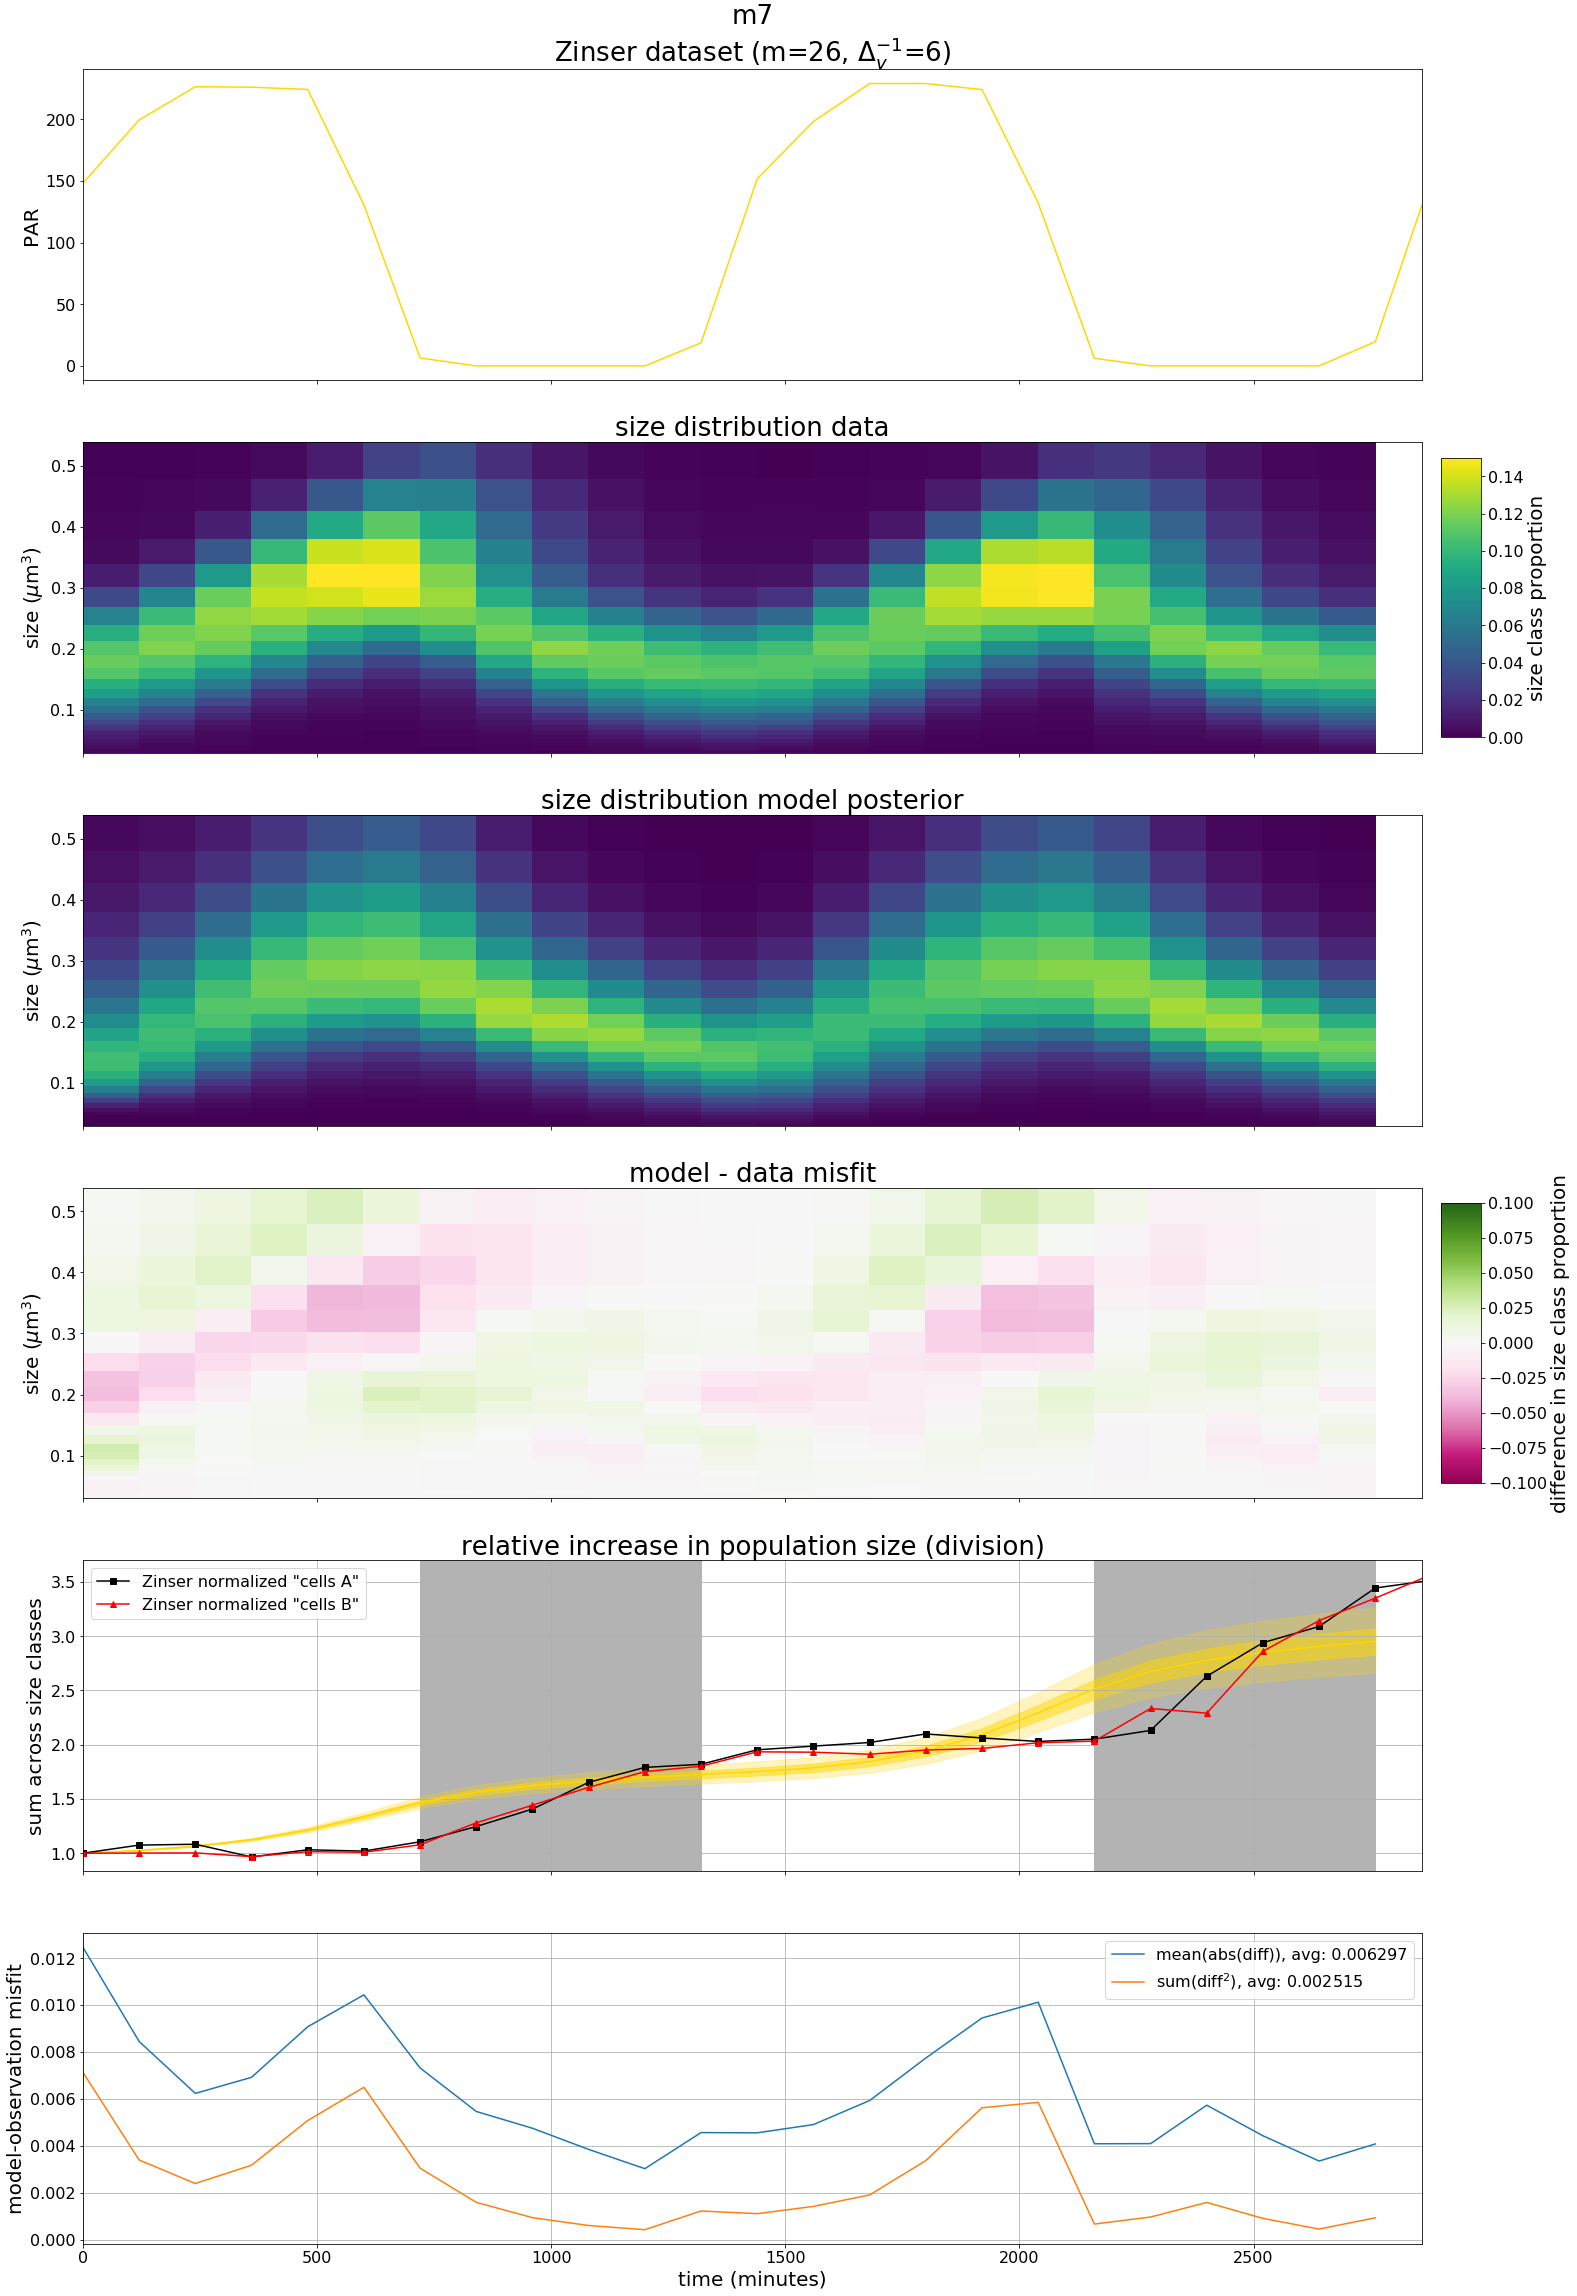

In [12]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
        
    for name,mcmc in mcmcs.items():
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

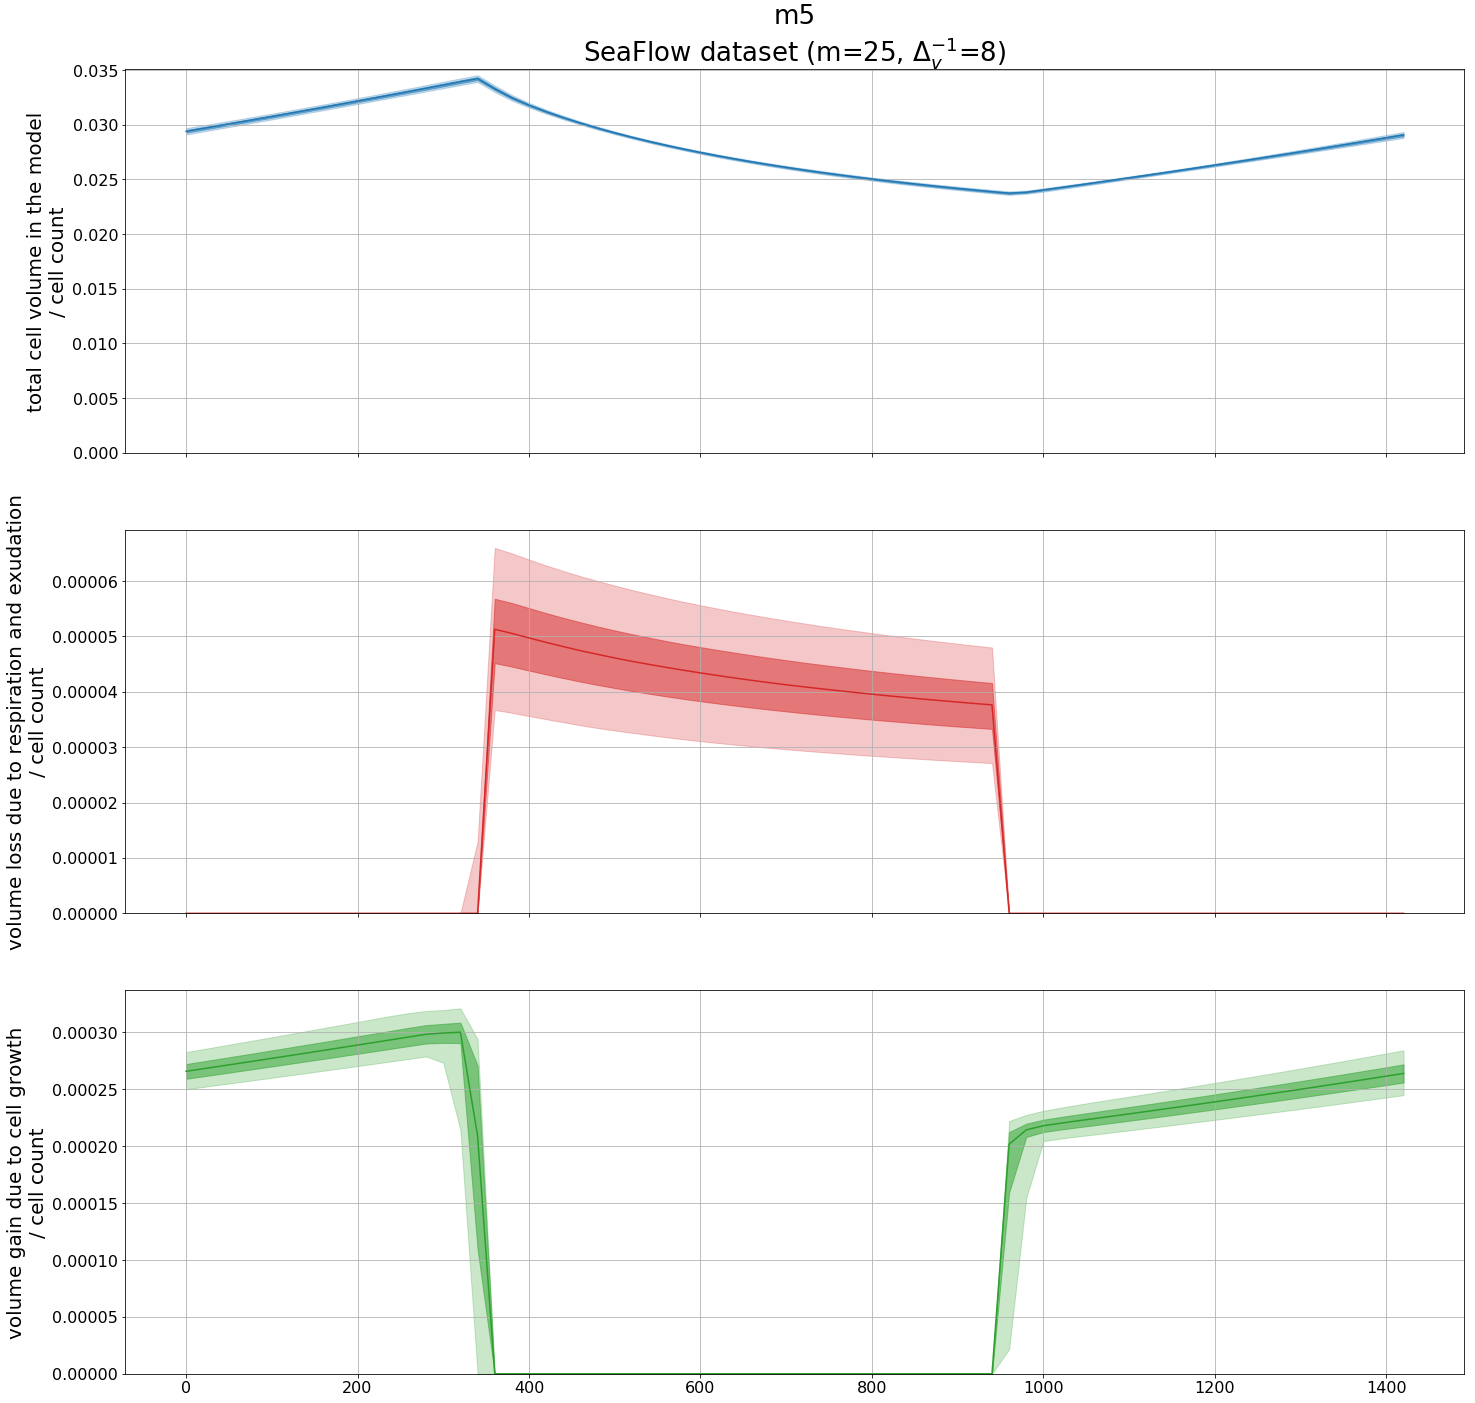

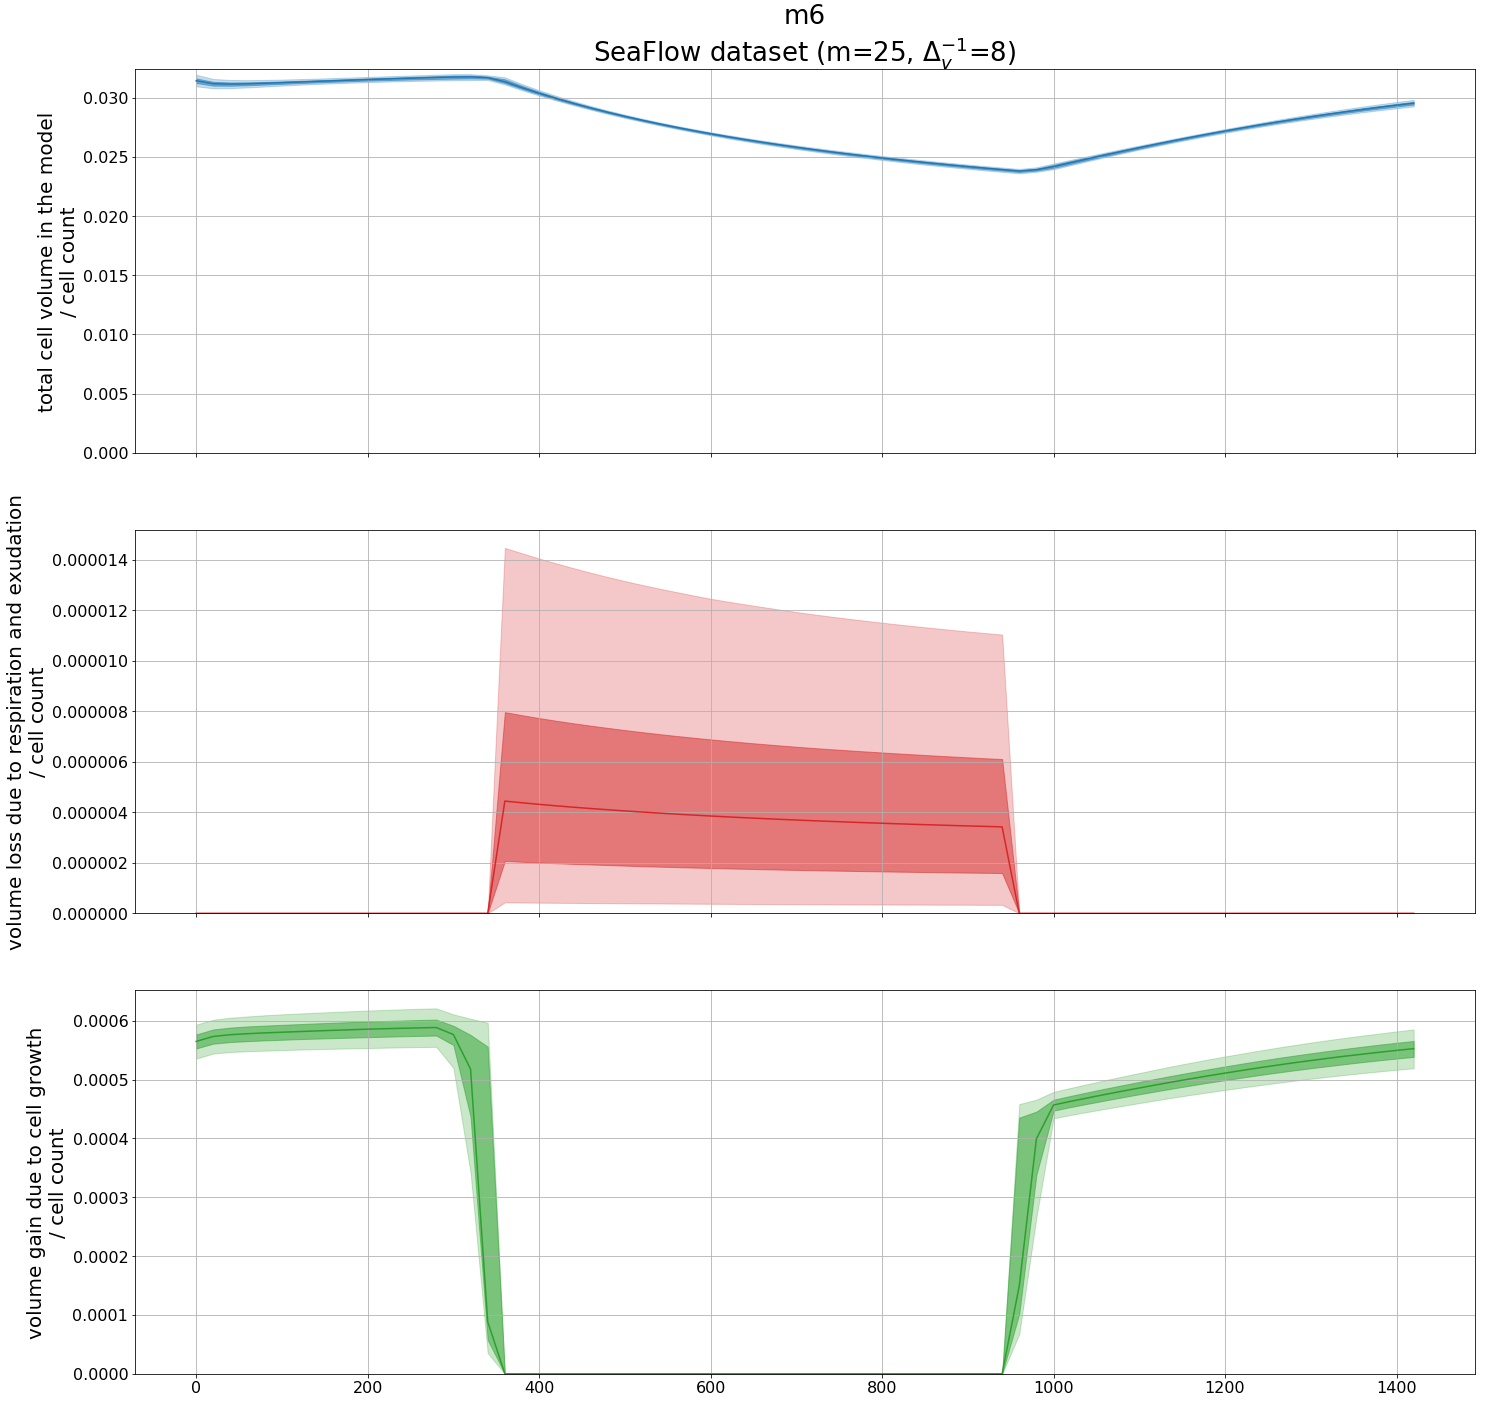

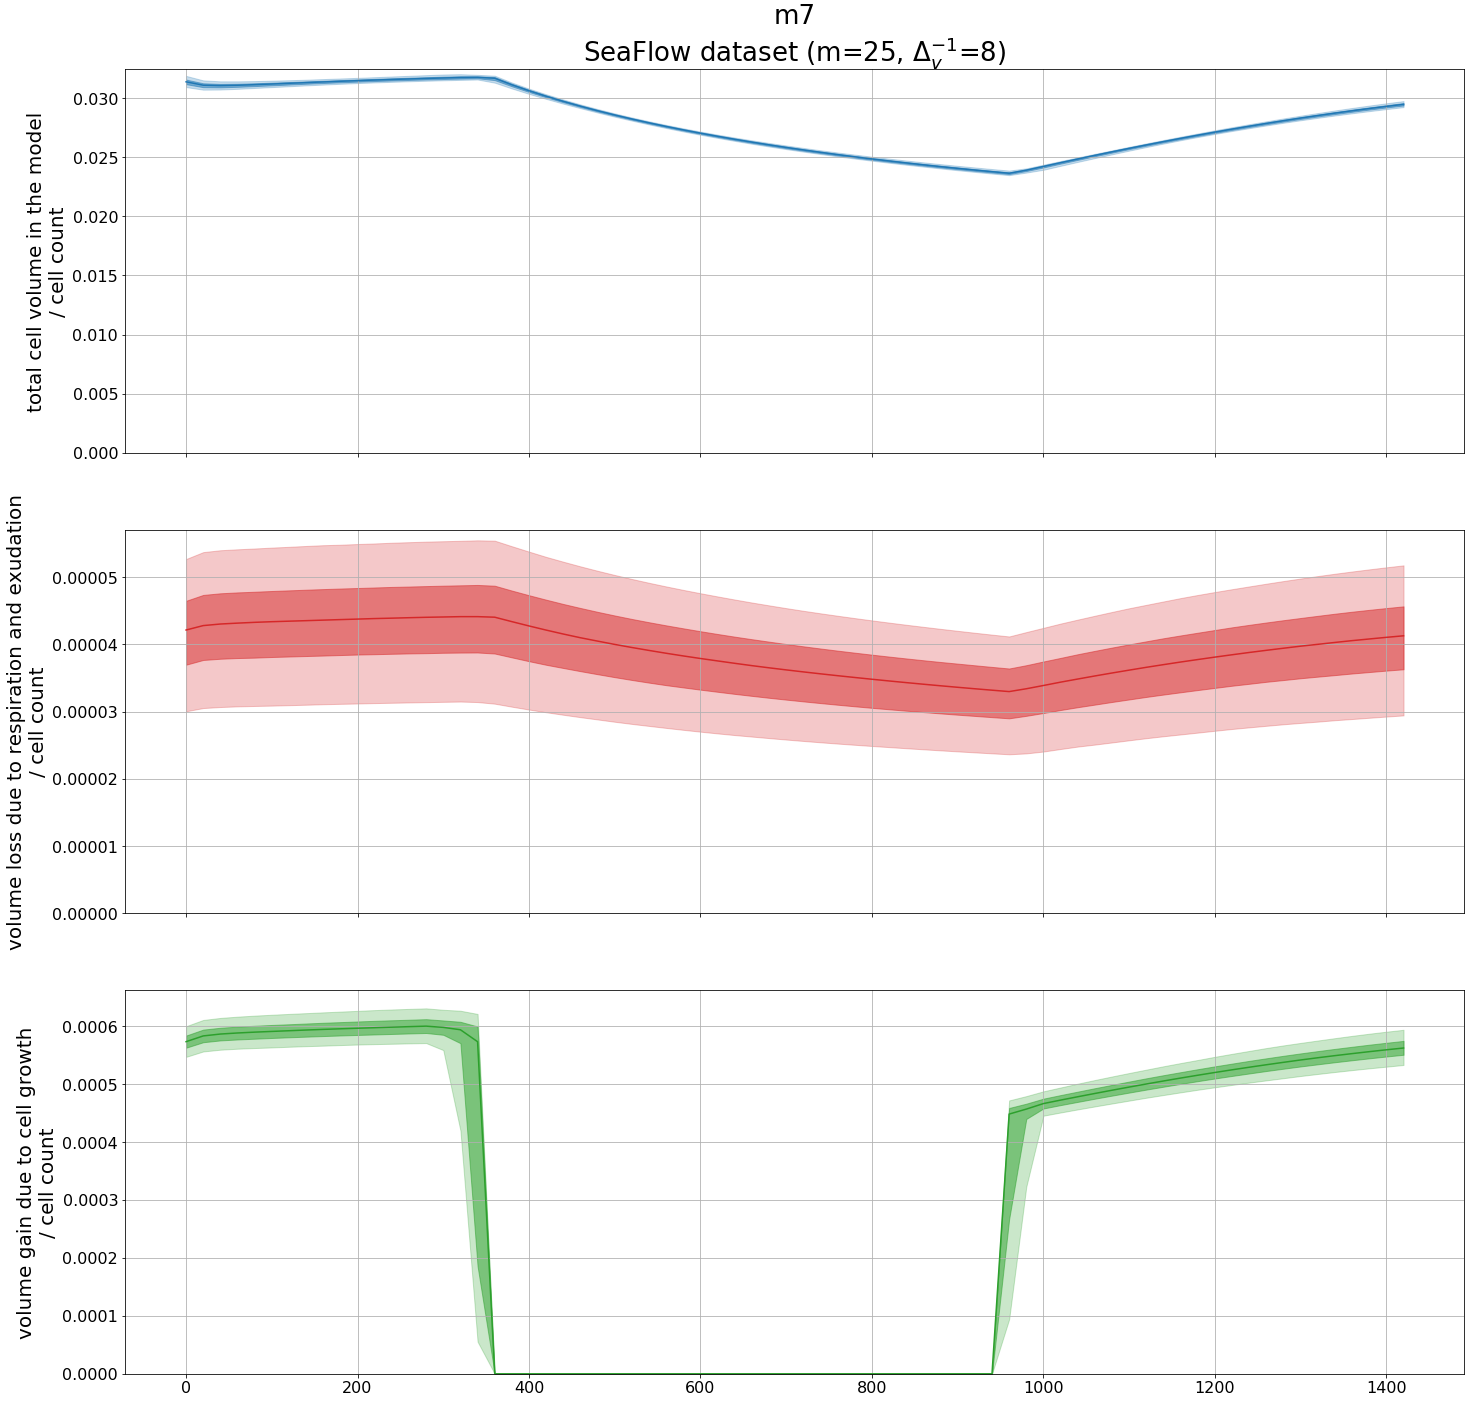

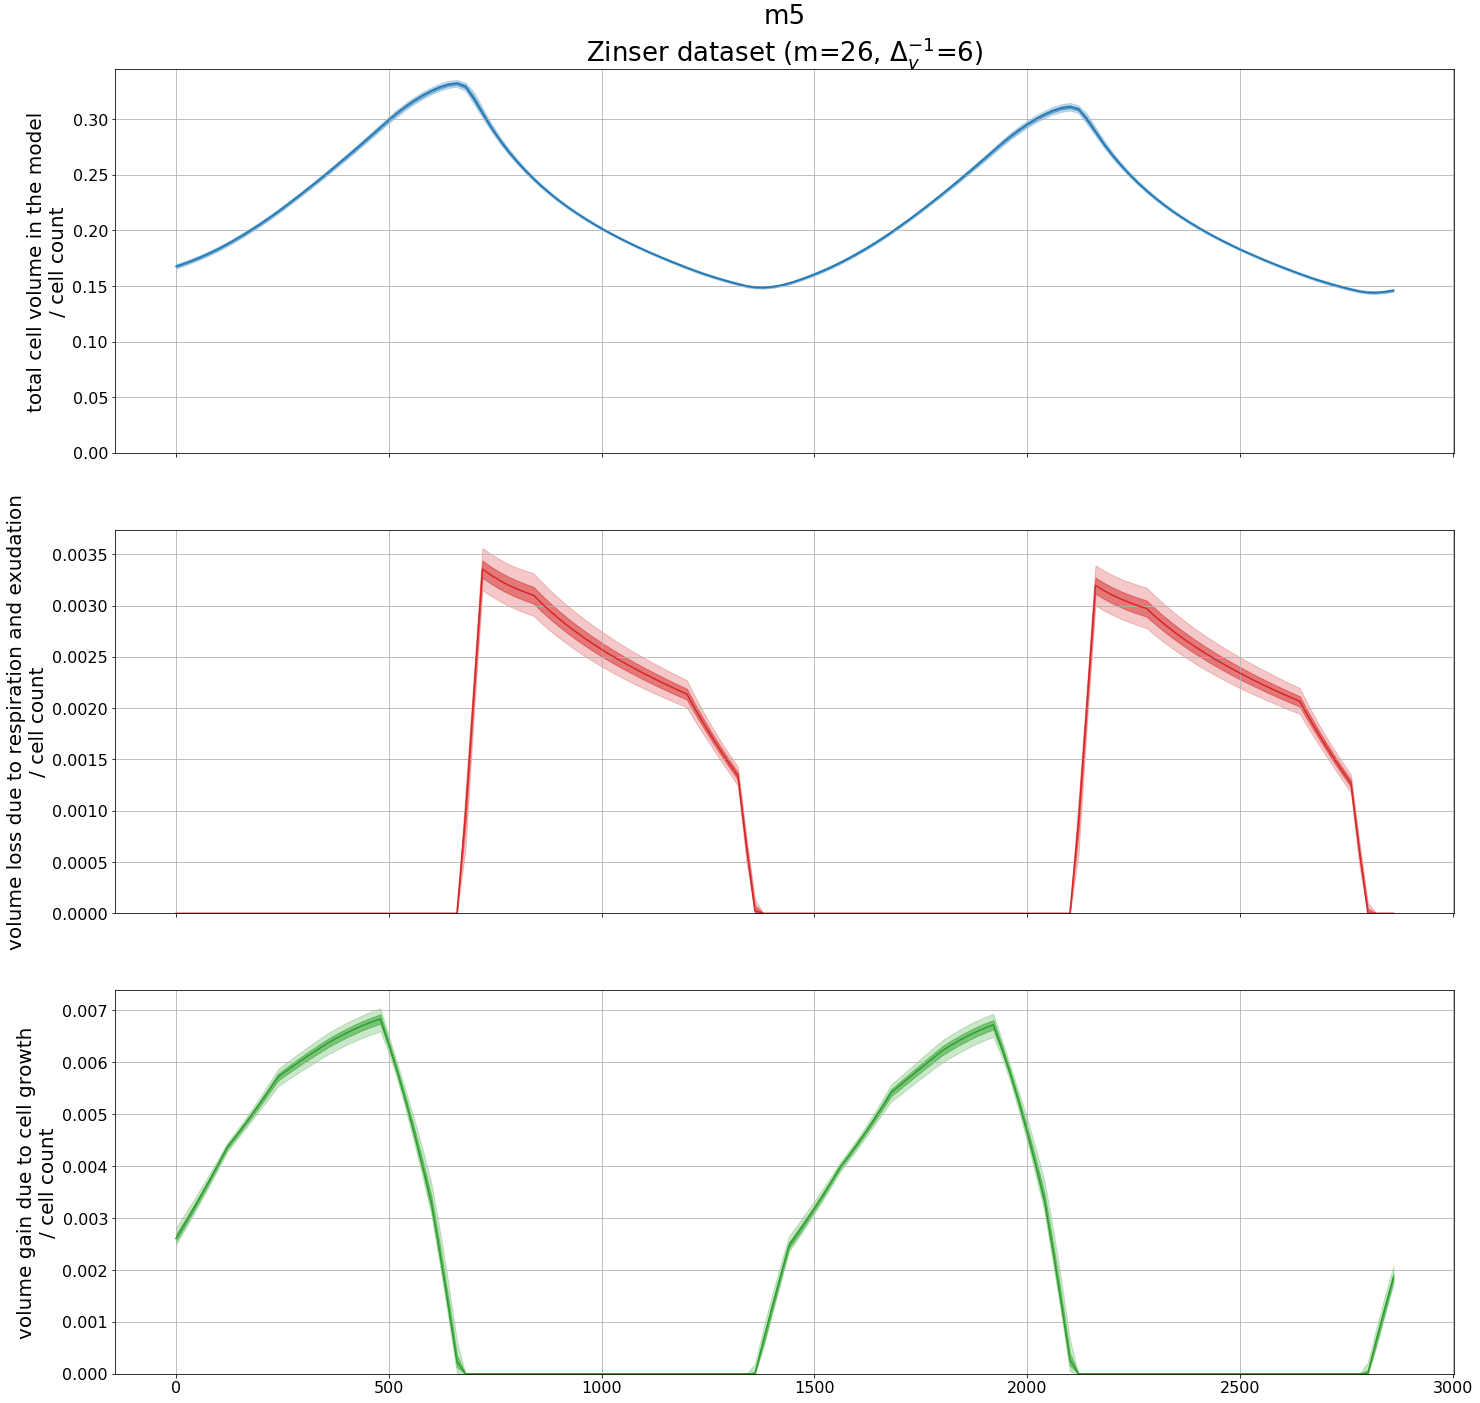

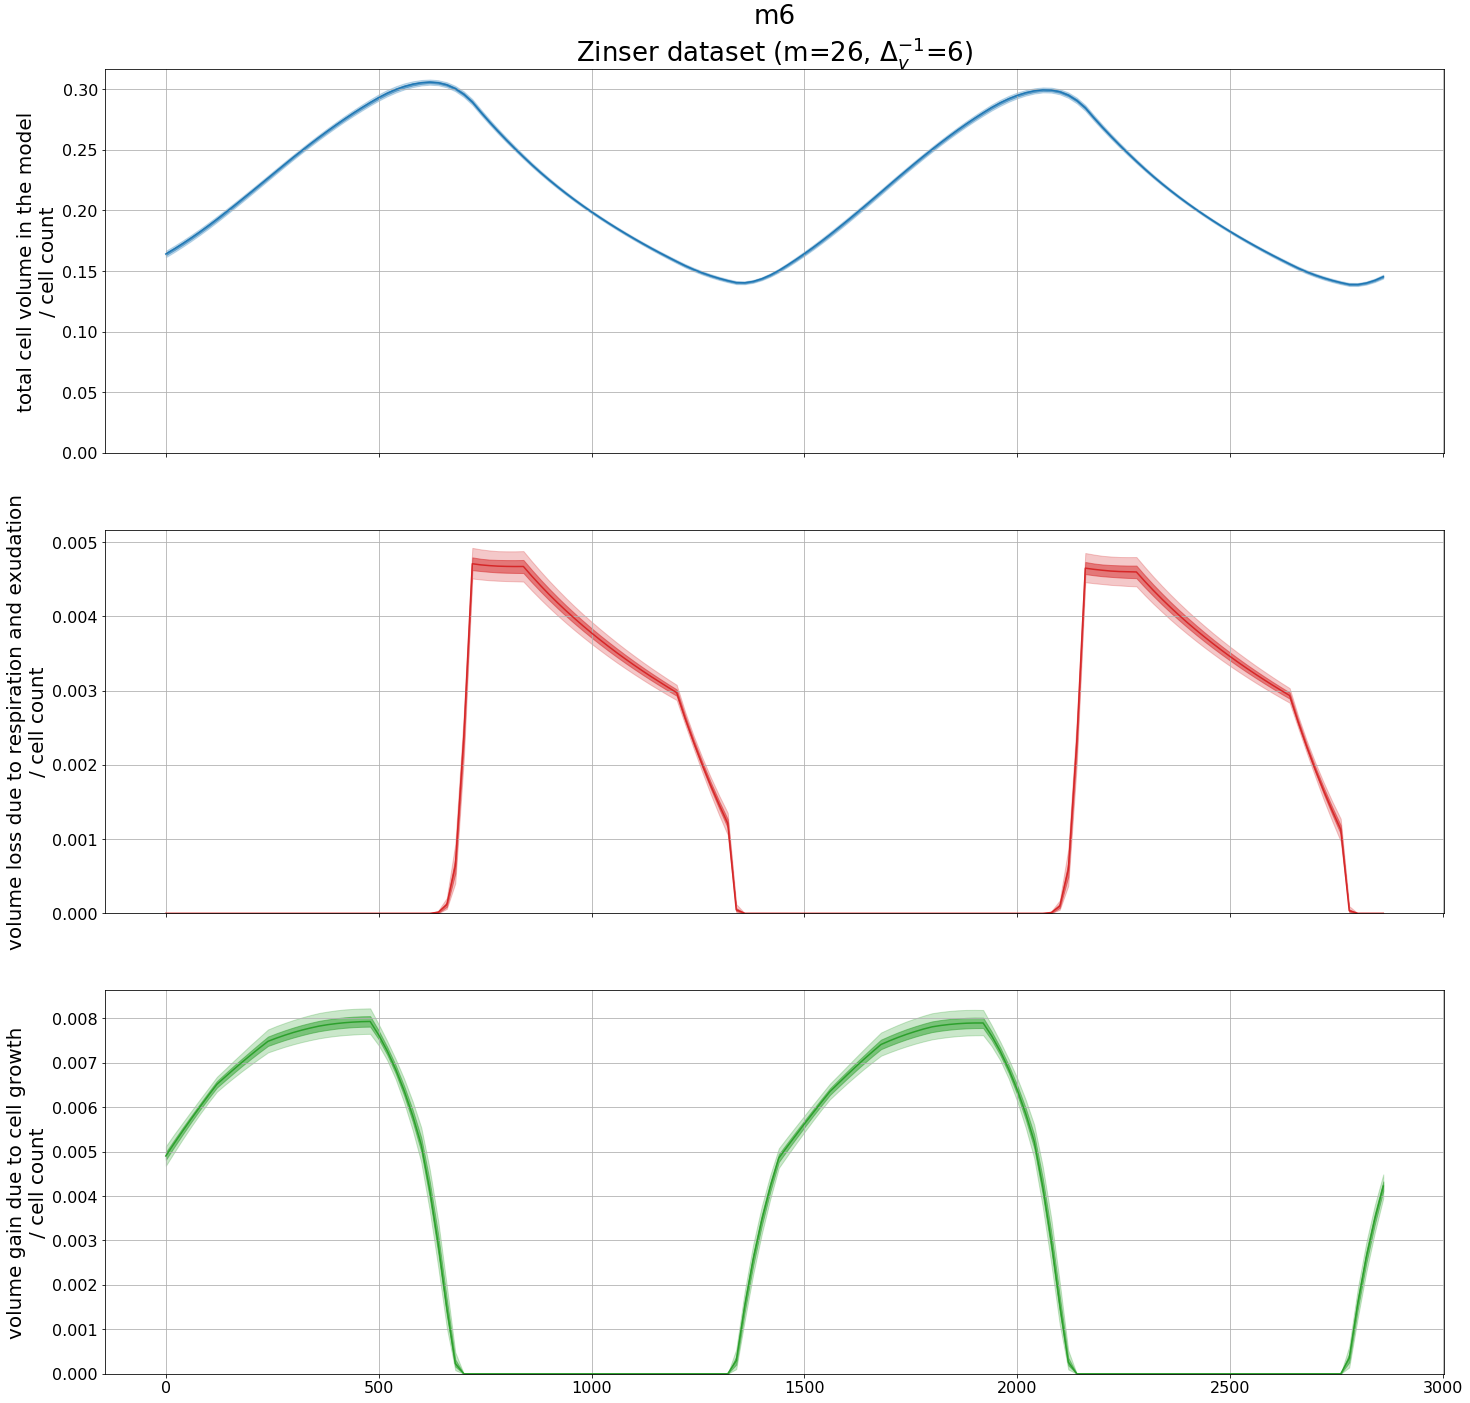

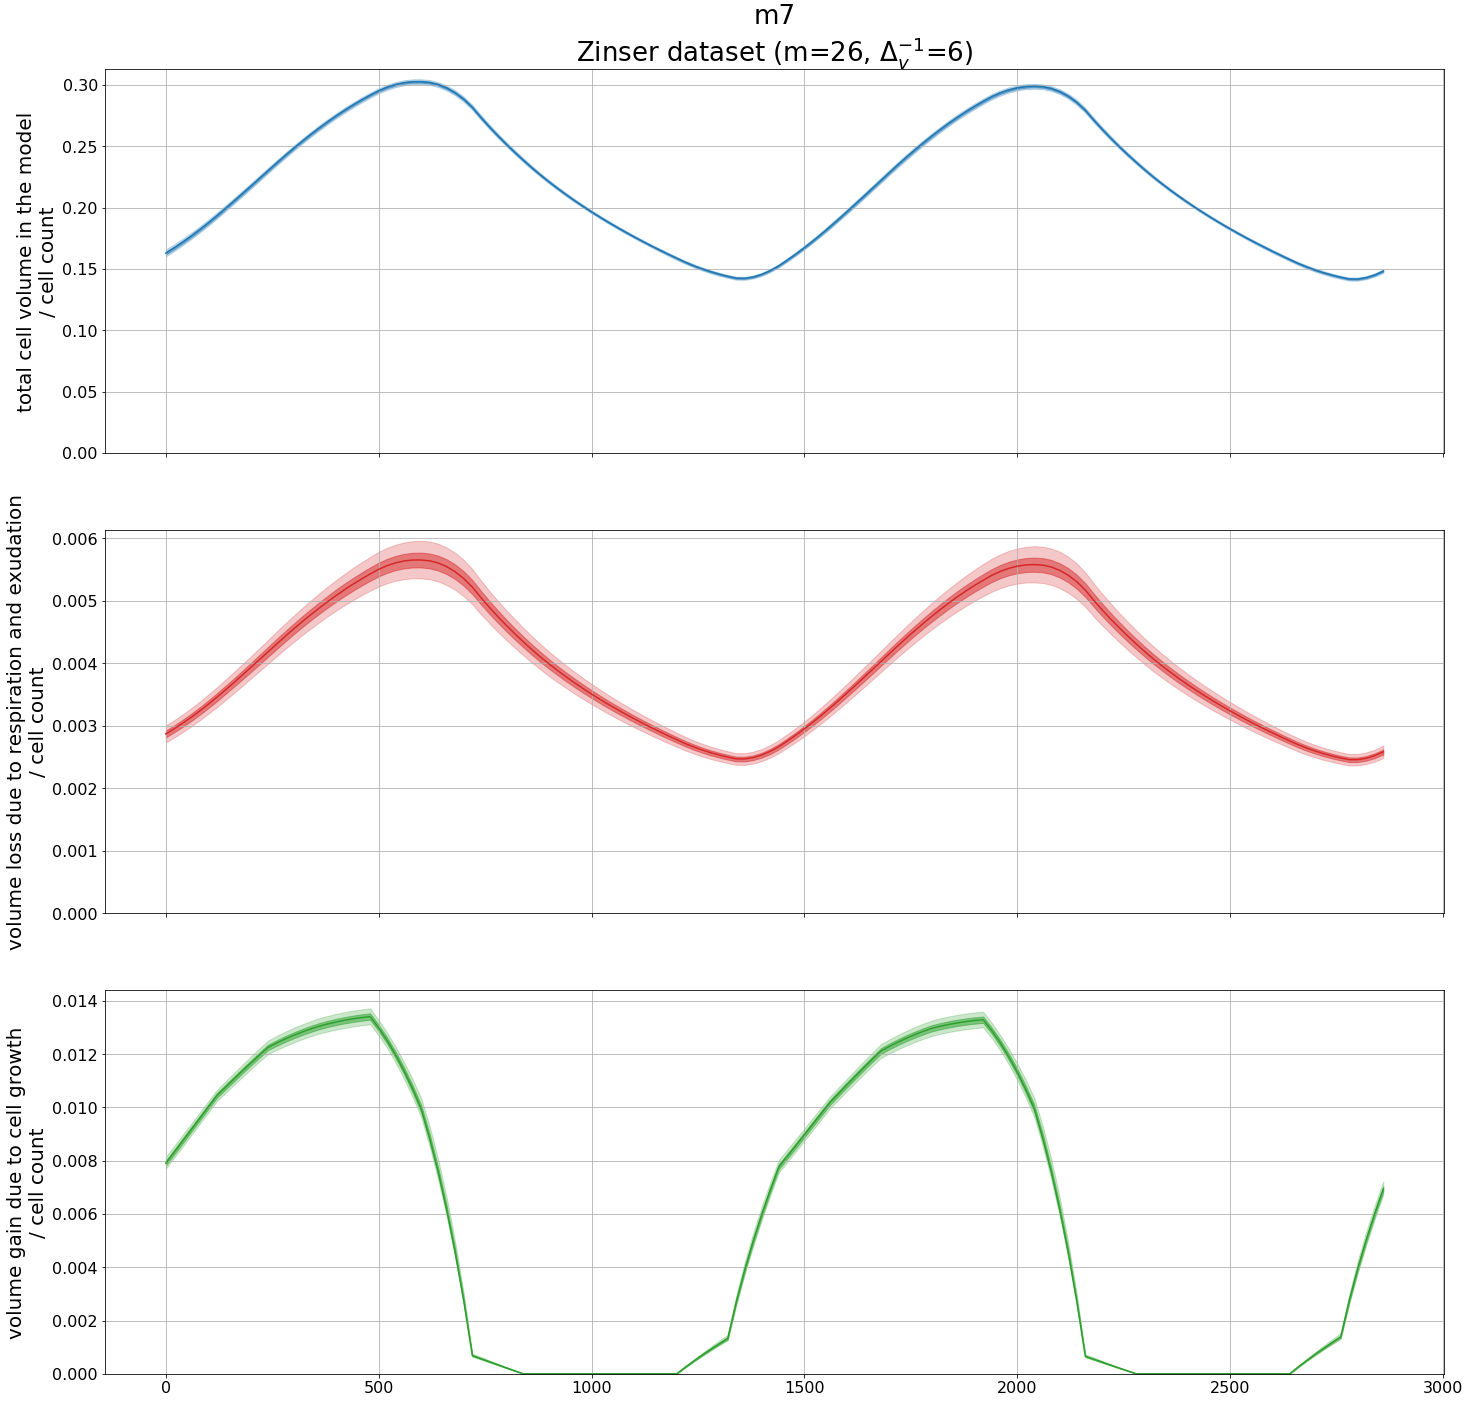

In [16]:
for dataname in data:
    
    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v_ext = v_min * 2**(np.arange(data[dataname]['m']+1)*delta_v)
    v_mid = 0.5*(v[1:]+v[:-1])
    
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    
    for name,mcmc in mcmcs.items():
        qq = {var:np.percentile(mcmc[dataname][var]/mcmc[dataname]['cell_count'], q=(5,25,50,75,95), axis=0) for var in desc_var}
        
        nrows = len(qq)
        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(24,8*nrows))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        for var,ax in zip(qq,axs.flat):
            ax.fill_between(t, qq[var][0,:], qq[var][-1,:], alpha=0.25, color=color_var[var])
            ax.fill_between(t, qq[var][1,:], qq[var][-2,:], alpha=0.5, color=color_var[var])
            ax.plot(t, qq[var][2,:], color=color_var[var])
            ax.grid(True)
            ax.set_ylim(bottom=0.0)
            ax.set_ylabel(desc_var[var]+'\n/ cell count')